<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1">Dependencies</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2">Functions</a></span></li><li><span><a href="#Paths" data-toc-modified-id="Paths-3">Paths</a></span></li><li><span><a href="#Main" data-toc-modified-id="Main-4">Main</a></span></li><li><span><a href="#Assign-genes-to-specific-immune-celltypes" data-toc-modified-id="Assign-genes-to-specific-immune-celltypes-5">Assign genes to specific immune celltypes</a></span><ul class="toc-item"><li><span><a href="#1--gene-regulation-atlas-of-28-immune-cell-types-(immunexut)" data-toc-modified-id="1--gene-regulation-atlas-of-28-immune-cell-types-(immunexut)-5.1">1- gene-regulation atlas of 28 immune cell types (immunexut)</a></span></li><li><span><a href="#2--blood-gene-expression-from-proteinatlas" data-toc-modified-id="2--blood-gene-expression-from-proteinatlas-5.2">2- blood gene expression from proteinatlas</a></span></li><li><span><a href="#3--MCPcounter" data-toc-modified-id="3--MCPcounter-5.3">3- MCPcounter</a></span></li><li><span><a href="#4--CIBERSORT" data-toc-modified-id="4--CIBERSORT-5.4">4- CIBERSORT</a></span></li><li><span><a href="#5--Quantiseq" data-toc-modified-id="5--Quantiseq-5.5">5- Quantiseq</a></span></li><li><span><a href="#6--EPIC" data-toc-modified-id="6--EPIC-5.6">6- EPIC</a></span></li><li><span><a href="#7--Xcell" data-toc-modified-id="7--Xcell-5.7">7- Xcell</a></span></li></ul></li><li><span><a href="#Compile-all-celltypes" data-toc-modified-id="Compile-all-celltypes-6">Compile all celltypes</a></span></li><li><span><a href="#Manual-review" data-toc-modified-id="Manual-review-7">Manual review</a></span></li><li><span><a href="#Determine-clusters-with-CC" data-toc-modified-id="Determine-clusters-with-CC-8">Determine clusters with CC</a></span></li><li><span><a href="#Heatmaps" data-toc-modified-id="Heatmaps-9">Heatmaps</a></span></li><li><span><a href="#Ridge-plots-and-stats" data-toc-modified-id="Ridge-plots-and-stats-10">Ridge plots and stats</a></span></li><li><span><a href="#Heatmap-Cancer-type" data-toc-modified-id="Heatmap-Cancer-type-11">Heatmap Cancer type</a></span></li><li><span><a href="#Heatmap-TCGA-cluster" data-toc-modified-id="Heatmap-TCGA-cluster-12">Heatmap TCGA cluster</a></span></li></ul></div>

# Dependencies

In [1]:
library(Biobase)
library(ConsensusClusterPlus)
library(GSVA)
library(biomaRt)

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bi

# Functions

In [2]:
source("~/OneDrive - UHN/R_src/ggplot2_theme.R")
source("~/OneDrive - UHN/R_src/Heatmap_functions.R")
source("~/OneDrive - UHN/R_src/plotting_functions.R")
source("~/OneDrive - UHN/R_src/color_schemes.R")

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


circlize version 0.4.12
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




In [3]:
mcentr <- function(x) {
    meds <- median(x, na.rm=T)
    mads <- mad(x, na.rm=T)
    if (mads == 0) {
        rep(0, length(x))} else { (x - meds) / mads}
}

# Paths

In [4]:
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Manifests/"
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/IPD2/Plots/"

# Main

In [5]:
load(paste0(datapath, "exp_mat/IPD_ExprSet_log2_combat.RData"))

In [6]:
vars <- pData(IPD_Set_log2_combat)
tpms <- exprs(IPD_Set_log2_combat)

In [7]:
#rename TCGA clusters
vars$CRI_cluster[which(vars$CRI_cluster == 1)] <- "Wound Healing"
vars$CRI_cluster[which(vars$CRI_cluster == 2)] <- "IFN-gamma dominant"
vars$CRI_cluster[which(vars$CRI_cluster == 3)] <- "Inflammatory"
vars$CRI_cluster[which(vars$CRI_cluster == 4)] <- "Lymphocyte depleted"
vars$CRI_cluster[which(vars$CRI_cluster == 5)] <- "Immunologically quiet"
vars$CRI_cluster[which(vars$CRI_cluster == 6)] <- "TGFbeta dominant"

In [8]:
load(file = paste0(datapath, "TME_clusters/TME_immune_genes.RData"))

# Assign genes to specific immune celltypes

## 1- gene-regulation atlas of 28 immune cell types (immunexut)

In [18]:
# These are average counts 
immunexut <- read.csv(paste0(datapath, "TME_clusters/cell_specific_genes_in_immunediseases.csv"), 
                      header = TRUE, stringsAsFactors = FALSE)

In [19]:
dim(immunexut)

[1] 7172   27

In [20]:
head(immunexut)

,Cell.type,Gene,Naïve.CD4,Th1,Th2,Th17,Tfh,Fr..I.nTreg,Fr..II.eTreg,Fr..III.T,⋯,SM.B,Plasmablast,DN.B,CL.Mono,Int.Mono,NC.Mono,mDC,pDC,Neu,LDG
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Naïve CD4,AC000068.3,2.28,1.24,1.45,1.35,1.44,1.64,1.17,1.48,⋯,1.17,0.58,1.16,0.98,0.64,0.91,0.58,1.22,0.42,0.73
2,Naïve CD4,AC005674.2,25.12,12.23,14.69,11.50,16.04,21.41,7.34,12.95,⋯,8.44,0.26,5.94,2.86,3.61,7.19,3.12,5.82,5.56,10.16
3,Naïve CD4,AC005920.1,9.05,3.17,2.58,3.55,3.33,7.22,1.67,2.96,⋯,0.04,0.02,0.04,0.13,0.19,0.37,0.31,0.01,0.02,0.10
4,Naïve CD4,AC006252.1,7.79,3.06,3.52,3.64,4.04,4.50,2.66,3.26,⋯,2.85,3.53,3.19,1.22,0.73,0.86,0.94,1.87,0.65,0.84
5,Naïve CD4,AC009041.2,34.88,9.41,20.69,8.42,11.79,9.36,0.09,2.78,⋯,0.18,0.01,0.09,0.01,0.01,0.01,0.00,0.20,0.01,0.22
6,Naïve CD4,AC011726.3,3.22,0.22,0.47,0.14,0.40,0.38,0.02,0.03,⋯,0.03,0.01,0.03,0.39,0.12,0.03,0.04,0.01,0.10,0.12


In [21]:
table(immunexut$Cell.type)


     CL Mono       CM CD8         DN B       EM CD8  Fr. I nTreg Fr. II eTreg 
         437           12          145           61           87          395 
   Fr. III T     Int Mono          LDG          mDC      Naïve B    Naïve CD4 
           3          132          720          414          543          135 
   Naïve CD8      NC Mono          Neu           NK          pDC  Plasmablast 
         223          430          654          486         1115          686 
        SM B    TEMRA CD8          Tfh          Th1         Th17          Th2 
          70          105           20            7           95           63 
       USM B 
         134 

In [22]:
tmp <- immunexut[,3:ncol(immunexut)]

In [23]:
#median center
immunexut_m <- (tmp - median(unlist(tmp)))/ mad(unlist(tmp))

In [24]:
rownames(immunexut_m) <- immunexut$Gene

In [25]:
head(immunexut_m)

,Naïve.CD4,Th1,Th2,Th17,Tfh,Fr..I.nTreg,Fr..II.eTreg,Fr..III.T,Naïve.CD8,CM.CD8,⋯,SM.B,Plasmablast,DN.B,CL.Mono,Int.Mono,NC.Mono,mDC,pDC,Neu,LDG
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AC000068.3,-0.15193307,-0.39134276,-0.34300042,-0.3660206,-0.34530244,-0.2992621,-0.40745688,-0.336094372,-0.2440137,-0.35911453,⋯,-0.40745688,-0.5432758,-0.40975889,-0.45119518,-0.5294637,-0.4673093,-0.54327583,-0.3959468,-0.5801081,-0.5087456
AC005674.2,5.10587203,2.13857309,2.70486909,1.9705259,3.01564128,4.2518240,1.01288715,2.304318260,3.5197828,2.06951260,⋯,1.26610893,-0.6169404,0.69060487,-0.01841613,0.1542351,0.9783569,0.04143629,0.6629807,0.6031283,1.6620557
AC005920.1,1.40653193,0.05294637,-0.08287258,0.1404230,0.08977863,0.9852630,-0.29235606,0.004604032,1.0566255,-0.03222823,⋯,-0.66758471,-0.6721887,-0.66758471,-0.64686656,-0.6330545,-0.5916182,-0.60543027,-0.6744908,-0.6721887,-0.6537726
AC006252.1,1.11647788,0.02762419,0.13351694,0.1611411,0.25322179,0.3591145,-0.06445645,0.073664520,0.8977863,0.06215444,⋯,-0.02071815,0.1358190,0.05755041,-0.39594679,-0.5087456,-0.4788194,-0.46040325,-0.2463157,-0.5271617,-0.4834234
AC009041.2,7.35263988,1.48940451,4.08607883,1.2615049,2.03728438,1.4778944,-0.65607463,-0.036832260,6.5676523,2.29511020,⋯,-0.63535648,-0.6744908,-0.65607463,-0.67449076,-0.6744908,-0.6744908,-0.67679278,-0.6307525,-0.6744908,-0.6261484
AC011726.3,0.06445645,-0.62614842,-0.56859801,-0.6445645,-0.58471213,-0.5893162,-0.67218874,-0.669886727,-0.3015641,-0.62845043,⋯,-0.66988673,-0.6744908,-0.66988673,-0.58701414,-0.6491686,-0.6698867,-0.66758471,-0.6744908,-0.6537726,-0.6491686


In [26]:
summary(unlist(tmp))

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    0.00     0.26     2.94    50.60    30.00 55587.39 

In [27]:
summary(unlist(immunexut_m))

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
   -0.677    -0.617     0.000    10.970     6.229 12795.631 

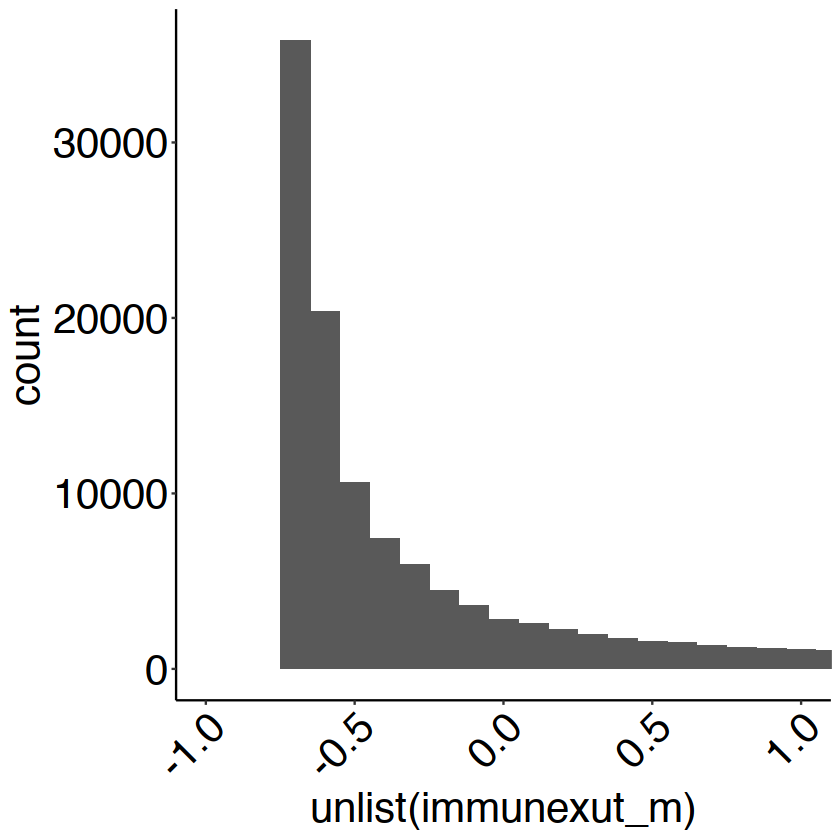

In [28]:
ggplot() + geom_histogram(aes(unlist(immunexut_m)), binwidth = 0.1) + myaxis + myplot +
coord_cartesian(xlim = c(-1,1))

In [29]:
immunexut_expressed_genes <- rownames(immunexut_m)[rowSums(immunexut_m > quantile(unlist(immunexut_m),0.75)) >= 1]

In [30]:
dim(immunexut_m)

[1] 7172   25

In [31]:
length(immunexut_expressed_genes)

[1] 3896

In [32]:
# get median scores for genes for all celltypes
immunexut_genes_mcentr <- t(apply(immunexut[,3:ncol(immunexut)],1,mcentr))

In [33]:
rownames(immunexut_genes_mcentr) <- immunexut$Gene
colnames(immunexut_genes_mcentr) <- colnames(immunexut)[3:ncol(immunexut)]

In [34]:
head(immunexut_genes_mcentr)

,Naïve.CD4,Th1,Th2,Th17,Tfh,Fr..I.nTreg,Fr..II.eTreg,Fr..III.T,Naïve.CD8,CM.CD8,⋯,SM.B,Plasmablast,DN.B,CL.Mono,Int.Mono,NC.Mono,mDC,pDC,Neu,LDG
AC000068.3,3.108523,0.05865137,0.6744908,0.3812339,0.6451651,1.231679,-0.1466284,0.7624678,1.935495,0.4692110,⋯,-0.14662843,-1.8768439,-0.1759541,-0.7038164,-1.7008897,-0.9090962,-1.8768439,0.00000000,-2.3460548,-1.4369586
AC005674.2,3.676636,0.83539869,1.3776364,0.6744908,1.6752058,2.858871,-0.2424640,0.9941024,2.157930,0.7692721,⋯,0.00000000,-1.8030505,-0.5510545,-1.2299537,-1.0646374,-0.2755273,-1.1726441,-0.57750516,-0.6348148,0.3791255
AC005920.1,11.281189,3.50470689,2.7244137,4.0072686,3.7163118,8.860957,1.5209105,3.2269754,9.270942,3.0153705,⋯,-0.63481483,-0.6612655,-0.6348148,-0.5157871,-0.4364352,-0.1983796,-0.2777315,-0.67449076,-0.6612655,-0.5554630
AC006252.1,5.028022,0.19417158,0.6642712,0.7869059,1.1956882,1.665788,-0.2146107,0.3985627,4.057164,0.3474649,⋯,-0.02043911,0.6744908,0.3270258,-1.6862269,-2.1869852,-2.0541309,-1.9723745,-1.02195570,-2.2687416,-2.0745701
AC009041.2,111.323094,29.51700038,65.7467897,26.3372582,37.1612290,29.356407,-0.4175419,8.2223635,100.370649,40.7585130,⋯,-0.12847443,-0.6744908,-0.4175419,-0.6744908,-0.6744908,-0.6744908,-0.7066094,-0.06423722,-0.6744908,0.0000000
AC011726.3,26.305140,1.01173614,3.1195198,0.3372454,2.5293403,2.360718,-0.6744908,-0.5901794,12.899636,0.9274248,⋯,-0.59017941,-0.7588021,-0.5901794,2.4450290,0.1686227,-0.5901794,-0.5058681,-0.75880210,0.0000000,0.1686227


In [35]:
# get a list of tables with fold difference across celltype medians for each gene
diff_gen_list_immunexut <- mclapply(rownames(immunexut_genes_mcentr), function(x){
    mygen <- x
    gen_df <- immunexut_genes_mcentr[mygen,]
    #get z-score difference across cell types
    tab_diff <- outer(gen_df, gen_df, "-")
    #keep immune cells in rows and non-immune in cols    
    return(tab_diff)    
})

names(diff_gen_list_immunexut) <- rownames(immunexut_genes_mcentr)

In [36]:
#row value - col value
diff_gen_list_immunexut[["CD8A"]]

,Naïve.CD4,Th1,Th2,Th17,Tfh,Fr..I.nTreg,Fr..II.eTreg,Fr..III.T,Naïve.CD8,CM.CD8,⋯,SM.B,Plasmablast,DN.B,CL.Mono,Int.Mono,NC.Mono,mDC,pDC,Neu,LDG
Naïve.CD4,0.00000000,-2.508263,0.12646702,-0.69556860,-0.56910158,-0.61125725,-0.29508971,-0.27401187,-1654.3994,-1554.2796,⋯,-0.65341292,0.10538918,-0.8220356,0.14754485,0.10538918,2.107784e-01,0.00000000,-0.04215567,-0.27401187,-11.382032
Th1,2.50826251,0.000000,2.63472953,1.81269392,1.93916093,1.89700526,2.21317280,2.23425064,-1651.8911,-1551.7714,⋯,1.85484959,2.61365169,1.6862269,2.65580737,2.61365169,2.719041e+00,2.50826251,2.46610684,2.23425064,-8.873769
Th2,-0.12646702,-2.634730,0.00000000,-0.82203561,-0.69556860,-0.73772427,-0.42155672,-0.40047889,-1654.5258,-1554.4061,⋯,-0.77987994,-0.02107784,-0.9485026,0.02107784,-0.02107784,8.431134e-02,-0.12646702,-0.16862269,-0.40047889,-11.508499
Th17,0.69556860,-1.812694,0.82203561,0.00000000,0.12646702,0.08431134,0.40047889,0.42155672,-1653.7038,-1553.5841,⋯,0.04215567,0.80095778,-0.1264670,0.84311345,0.80095778,9.063470e-01,0.69556860,0.65341292,0.42155672,-10.686463
Tfh,0.56910158,-1.939161,0.69556860,-0.12646702,0.00000000,-0.04215567,0.27401187,0.29508971,-1653.8303,-1553.7105,⋯,-0.08431134,0.67449076,-0.2529340,0.71664643,0.67449076,7.798799e-01,0.56910158,0.52694591,0.29508971,-10.812930
Fr..I.nTreg,0.61125725,-1.897005,0.73772427,-0.08431134,0.04215567,0.00000000,0.31616754,0.33724538,-1653.7881,-1553.6684,⋯,-0.04215567,0.71664643,-0.2107784,0.75880210,0.71664643,8.220356e-01,0.61125725,0.56910158,0.33724538,-10.770774
Fr..II.eTreg,0.29508971,-2.213173,0.42155672,-0.40047889,-0.27401187,-0.31616754,0.00000000,0.02107784,-1654.1043,-1553.9846,⋯,-0.35832322,0.40047889,-0.5269459,0.44263456,0.40047889,5.058681e-01,0.29508971,0.25293403,0.02107784,-11.086942
Fr..III.T,0.27401187,-2.234251,0.40047889,-0.42155672,-0.29508971,-0.33724538,-0.02107784,0.00000000,-1654.1254,-1554.0056,⋯,-0.37940105,0.37940105,-0.5480237,0.42155672,0.37940105,4.847902e-01,0.27401187,0.23185620,0.00000000,-11.108020
Naïve.CD8,1654.39936598,1651.891103,1654.52583300,1653.70379738,1653.83026440,1653.78810873,1654.10427627,1654.12535411,0.0000,100.1197,⋯,1653.74595306,1654.50475516,1653.5773304,1654.54691083,1654.50475516,1.654610e+03,1654.39936598,1654.35721031,1654.12535411,1643.017334
CM.CD8,1554.27964387,1551.771381,1554.40611089,1553.58407527,1553.71054229,1553.66838662,1553.98455416,1554.00563200,-100.1197,0.0000,⋯,1553.62623095,1554.38503305,1553.4576083,1554.42718872,1554.38503305,1.554490e+03,1554.27964387,1554.23748820,1554.00563200,1542.897612


Select genes if any immune cells express >=2 z compared to all nonimmune cells

In [37]:
diff_gen_list_immune_immunexut <- lapply(diff_gen_list_immunexut, function(x) x[ rowSums(x >= 2) == 24,,drop = F])

In [38]:
# rmeove empty lists
diff_gen_list_immune_immunexut <- diff_gen_list_immune_immunexut[sapply(diff_gen_list_immune_immunexut, function(x) length(unlist(x))) >= 25]

In [39]:
diff_gen_list_immune_immunexut$CD8A

,Naïve.CD4,Th1,Th2,Th17,Tfh,Fr..I.nTreg,Fr..II.eTreg,Fr..III.T,Naïve.CD8,CM.CD8,⋯,SM.B,Plasmablast,DN.B,CL.Mono,Int.Mono,NC.Mono,mDC,pDC,Neu,LDG
TEMRA.CD8,2513.258,2510.75,2513.384,2512.562,2512.689,2512.647,2512.963,2512.984,858.8586,958.9783,⋯,2512.605,2513.363,2512.436,2513.406,2513.363,2513.469,2513.258,2513.216,2512.984,2501.876


In [40]:
length(diff_gen_list_immune_immunexut)

[1] 4655

In [41]:
# select genes with z (of median expression across all celltypes) > 75th percentile

diff_gen_list_immune_immunexut_expressed <- diff_gen_list_immune_immunexut[names(diff_gen_list_immune_immunexut) %in% immunexut_expressed_genes]

In [42]:
length(diff_gen_list_immune_immunexut_expressed)

[1] 2555

In [43]:
#add cell type as a variable
diff_gen_list_immune_immunexut_expressed <- lapply(diff_gen_list_immune_immunexut_expressed, function(x){cbind.data.frame(x, rownames(x))})

In [44]:
immune_immunexut_expressed <- do.call("rbind", diff_gen_list_immune_immunexut_expressed)

In [45]:
colnames(immune_immunexut_expressed)[ colnames(immune_immunexut_expressed) == "rownames(x)"] <- "celltype"

In [46]:
immune_immunexut_expressed$Gene <- rownames(immune_immunexut_expressed)

In [47]:
head(immune_immunexut_expressed)

,Naïve.CD4,Th1,Th2,Th17,Tfh,Fr..I.nTreg,Fr..II.eTreg,Fr..III.T,Naïve.CD8,CM.CD8,⋯,DN.B,CL.Mono,Int.Mono,NC.Mono,mDC,pDC,Neu,LDG,celltype,Gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
AC009041.2,0,81.806094,45.576304,84.985836,74.161865,81.966687,111.74064,103.100730,10.952445,70.564581,⋯,111.740636,111.997585,111.997585,111.997585,112.029703,111.387331,111.99758,111.32309,Naïve.CD4,AC009041.2
ADTRP,0,62.938741,61.167559,57.903230,40.840158,7.409101,50.88544,52.965545,59.658965,68.411899,⋯,69.941088,69.961683,69.874153,69.590970,69.956534,69.750583,69.96168,69.51889,Naïve.CD4,ADTRP
AK5,0,41.412320,38.869737,45.784150,35.970486,14.743450,48.66221,46.094910,19.284786,41.977339,⋯,49.237825,49.251951,49.304921,49.297859,47.006003,49.085977,49.29786,48.98710,Naïve.CD4,AK5
ANKRD55,0,84.561156,29.469417,89.415824,53.567890,78.524048,96.28564,93.371171,98.159223,99.999500,⋯,101.206922,100.698972,101.048708,101.256884,100.882167,101.331828,99.94121,97.98436,Naïve.CD4,ANKRD55
B4GALT4,0,6.397443,7.130696,7.636564,7.863949,7.545865,8.29317,8.104109,7.911215,7.429618,⋯,7.244388,8.862911,9.095406,8.882072,7.269937,7.319758,10.33325,10.06371,Naïve.CD4,B4GALT4
CHRM3-AS2,0,23.827609,24.303400,24.913469,20.609612,8.939137,29.97409,27.707677,15.010330,28.034444,⋯,32.050342,32.052670,32.041028,31.989801,32.053446,32.057327,32.04336,31.85397,Naïve.CD4,CHRM3-AS2


In [48]:
dim(immune_immunexut_expressed)

[1] 2555   27

In [49]:
table(immune_immunexut_expressed$celltype)


     CL.Mono       CM.CD8         DN.B       EM.CD8  Fr..I.nTreg Fr..II.eTreg 
         176            1           28           11           20           99 
    Int.Mono          LDG          mDC      Naïve.B    Naïve.CD4    Naïve.CD8 
          40          210          153          178           20           30 
     NC.Mono          Neu           NK          pDC  Plasmablast         SM.B 
         158          242          173          532          385           13 
   TEMRA.CD8          Tfh          Th1         Th17          Th2        USM.B 
          29            1            1           21           10           24 

In [50]:
# group some immunexut cell types together
immune_immunexut_expressed$Cellgroup <- NA
immune_immunexut_expressed$Cellgroup[ grepl("CD8", immune_immunexut_expressed$celltype)] <- "T_cells"
immune_immunexut_expressed$Cellgroup[ immune_immunexut_expressed$celltype %in% 
                              c("Fr..I.nTreg", "Fr..II.eTreg", "Th17", "Th2","Th1", "Naïve.CD4", "Tfh")] <- "T_cells"
immune_immunexut_expressed$Cellgroup[ immune_immunexut_expressed$celltype %in% 
                              c("Naïve.B", "DN.B", "SM.B", "USM.B", "Plasmablast")] <- "B_cells"
immune_immunexut_expressed$Cellgroup[ immune_immunexut_expressed$celltype %in% 
                              c("CL.Mono", "Int.Mono", "NC.Mono")] <- "Monocytes"
immune_immunexut_expressed$Cellgroup[ immune_immunexut_expressed$celltype %in% 
                              c("LDG",  "Neu")] <- "Granulocytes"
immune_immunexut_expressed$Cellgroup[ immune_immunexut_expressed$celltype %in% 
                              c("pDC",  "mDC")] <- "DC"
immune_immunexut_expressed$Cellgroup[ immune_immunexut_expressed$celltype == "NK"] <- "NK_cells"

In [51]:
table(immune_immunexut_expressed$Cellgroup, useNA = "always")


     B_cells           DC Granulocytes    Monocytes     NK_cells      T_cells 
         628          685          452          374          173          243 
        <NA> 
           0 

## 2- blood gene expression from proteinatlas

In [52]:
proteinatlas <- read.csv(paste0(datapath, "TME_clusters/proteinatlas_v20.1.csv"), header = TRUE, stringsAsFactors = FALSE)

In [53]:
dim(proteinatlas)

[1] 19670   292

In [54]:
#remove irrelevant columns
rmcols <- colnames(proteinatlas)[ grepl("Cell.RNA...", colnames(proteinatlas))]
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("mouse", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("pig", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("Pathology", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("score", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("distribution", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("Blood.concentration", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("Secretome", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("Subcellular", colnames(proteinatlas))])
rmcols <- c(rmcols, colnames(proteinatlas)[ grepl("Brain.RNA", colnames(proteinatlas))])

In [55]:
proteinatlas <- proteinatlas[,! colnames(proteinatlas) %in% rmcols]

In [56]:
gene_cells_blood <- as.data.frame(proteinatlas$Gene)
gene_cells_blood$Celltype <- proteinatlas$RNA.blood.cell.specific.NX
colnames(gene_cells_blood) <- c("Gene", "Celltype")

In [57]:
dim(gene_cells_blood)

[1] 19670     2

In [58]:
head(gene_cells_blood)

,Gene,Celltype
,<chr>,<chr>
1,TSPAN6,naive CD4 T-cell: 6.6
2,TNMD,
3,DPM1,
4,SCYL3,
5,C1orf112,
6,FGR,


In [59]:
# rmeoves non specific genes
gene_cells_blood <- gene_cells_blood[ gene_cells_blood$Celltype != "",]

In [60]:
dim(gene_cells_blood)

[1] 5934    2

In [61]:
head(gene_cells_blood)

,Gene,Celltype
,<chr>,<chr>
1,TSPAN6,naive CD4 T-cell: 6.6
7,CFH,MAIT T-cell: 16.5
9,GCLC,NK-cell: 8.0
24,HS3ST1,memory B-cell: 7.3;naive B-cell: 15.8;plasmacytoid DC: 22.3
25,AOC1,eosinophil: 20.3
26,WNT16,memory B-cell: 13.1;naive B-cell: 11.8


In [62]:
#separate rows
gene_cells_blood_sep <- tidyr::separate_rows(gene_cells_blood, Celltype,sep = ";")

In [63]:
#seprate gene expression as a new column

gene_cells_blood_sep$NX <- gsub(".*:", "", gene_cells_blood_sep$Celltype)
gene_cells_blood_sep$Celltype <- gsub(":.*", "", gene_cells_blood_sep$Celltype)

gene_cells_blood_sep$NX <- as.numeric(gene_cells_blood_sep$NX)

In [64]:
table(gene_cells_blood_sep$Celltype)


              basophil     classical monocyte             eosinophil 
                   926                    496                    679 
              gdT-cell  intermediate monocyte            MAIT T-cell 
                   338                    517                    358 
         memory B-cell      memory CD4 T-cell      memory CD8 T-cell 
                   518                    246                    253 
            myeloid DC           naive B-cell       naive CD4 T-cell 
                   527                    519                    351 
      naive CD8 T-cell             neutrophil                NK-cell 
                   311                   1461                    472 
non-classical monocyte        plasmacytoid DC                  T-reg 
                   498                    818                    442 

In [65]:
# group some atlas cell types together
gene_cells_blood_sep$Cellgroup <- NA

gene_cells_blood_sep$Cellgroup[ grepl("CD8", gene_cells_blood_sep$Celltype)] <- "T_cells"
gene_cells_blood_sep$Cellgroup[ grepl("B-cell", gene_cells_blood_sep$Celltype)] <- "B_cells"
gene_cells_blood_sep$Cellgroup[ grepl("NK-cell", gene_cells_blood_sep$Celltype)] <- "NK_cells"
gene_cells_blood_sep$Cellgroup[ grepl("monocyte", gene_cells_blood_sep$Celltype)] <- "Monocytes"
gene_cells_blood_sep$Cellgroup[ grepl("myeloid DC", gene_cells_blood_sep$Celltype)] <- "DC"
gene_cells_blood_sep$Cellgroup[ grepl("plasmacytoid DC", gene_cells_blood_sep$Celltype)] <- "DC"
gene_cells_blood_sep$Cellgroup[gene_cells_blood_sep$Celltype == "neutrophil"] <- "Granulocytes"
gene_cells_blood_sep$Cellgroup[gene_cells_blood_sep$Celltype == "basophil"] <- "Granulocytes"
gene_cells_blood_sep$Cellgroup[gene_cells_blood_sep$Celltype == "eosinophil"] <- "Granulocytes"
gene_cells_blood_sep$Cellgroup[ gene_cells_blood_sep$Celltype %in% c("memory CD4 T-cell", "naive CD4 T-cell")] <- "T_cells"
gene_cells_blood_sep$Cellgroup[ grepl("T-reg", gene_cells_blood_sep$Celltype)] <- "T_cells"
gene_cells_blood_sep$Cellgroup[ grepl("gdT-cell", gene_cells_blood_sep$Celltype)] <- "T_cells"
gene_cells_blood_sep$Cellgroup[ grepl("MAIT T-cell", gene_cells_blood_sep$Celltype)] <- "T_cells"

In [66]:
head(gene_cells_blood_sep)

Gene,Celltype,NX,Cellgroup
<chr>,<chr>,<dbl>,<chr>
TSPAN6,naive CD4 T-cell,6.6,T_cells
CFH,MAIT T-cell,16.5,T_cells
GCLC,NK-cell,8.0,NK_cells
HS3ST1,memory B-cell,7.3,B_cells
HS3ST1,naive B-cell,15.8,B_cells
HS3ST1,plasmacytoid DC,22.3,DC


In [67]:
#rm genes if more than one cellgroup
gene_cells_blood_sep_specific <- gene_cells_blood_sep[0,]

for(g in unique(gene_cells_blood_sep$Gene)){
    tmp <- gene_cells_blood_sep[ gene_cells_blood_sep$Gene == g,]
    if(nrow(tmp) == 1){ 
    gene_cells_blood_sep_specific <- rbind(gene_cells_blood_sep_specific, tmp)
    } else{
    if(length(unique(tmp$Cellgroup)) == 1){ 
    gene_cells_blood_sep_specific <- rbind(gene_cells_blood_sep_specific, tmp)
    }}
    
}

In [68]:
dim(gene_cells_blood_sep)

[1] 9730    4

In [69]:
dim(gene_cells_blood_sep_specific)

[1] 5955    4

In [70]:
table(gene_cells_blood_sep_specific$Celltype)


              basophil     classical monocyte             eosinophil 
                   752                    119                    477 
              gdT-cell  intermediate monocyte            MAIT T-cell 
                   196                    195                    227 
         memory B-cell      memory CD4 T-cell      memory CD8 T-cell 
                   311                    134                    136 
            myeloid DC           naive B-cell       naive CD4 T-cell 
                   166                    315                    235 
      naive CD8 T-cell             neutrophil                NK-cell 
                   184                   1185                    245 
non-classical monocyte        plasmacytoid DC                  T-reg 
                   236                    539                    303 

## 3- MCPcounter

In [71]:
mcp_sig <- read.csv(file = paste0(datapath, "TME_clusters/MCPCounter_genesig.csv"), 
                       header = T, stringsAsFactors = F, check.names = T, skip =  1)

In [72]:
mcp_sig <- mcp_sig[,1:3]

In [73]:
# some probes map to the same gene
mcp_sig <- mcp_sig[!duplicated(mcp_sig$Symbol),]
# remove those probesets that map to two genes
mcp_sig <- mcp_sig[!grepl("///", mcp_sig$Symbol),]

In [74]:
head(mcp_sig)

,Probeset,Symbol,Population
,<chr>,<chr>,<chr>
1,1557733_a_at,CHRM3-AS2,T cells
2,1558971_at,THEMIS,T cells
4,1566448_at,CD6,T cells
5,204777_s_at,MAL,T cells
6,206485_at,CD5,T cells
7,206545_at,CD28,T cells


In [75]:
table(mcp_sig$Population)


              B lineage   Cytotoxic lymphocytes       Endothelial cells 
                     42                       7                      86 
            Fibroblasts       Monocytic lineage Myeloid dendritic cells 
                     63                       7                       6 
            Neutrophils                NK cells                 T cells 
                     53                       9                      16 

In [76]:
#Some recoding and cleanup

mcp_sig$Cellgroup <- NA

mcp_sig$Cellgroup[ mcp_sig$Population == "B lineage"] <- "B_cells"
mcp_sig$Cellgroup[ mcp_sig$Population == "Cytotoxic lymphocytes"] <- "T_cells"
mcp_sig$Cellgroup[ mcp_sig$Population == "Monocytic lineage"] <- "Monocytes"
mcp_sig$Cellgroup[ mcp_sig$Population == "Neutrophils"] <- "Granulocytes"
mcp_sig$Cellgroup[ mcp_sig$Population == "NK cells"] <- "NK_cells"
mcp_sig$Cellgroup[ mcp_sig$Population == "T cells"] <- "T_cells"
mcp_sig$Cellgroup[ mcp_sig$Population == "Myeloid dendritic cells"] <- "DC"

mcp_sig <- mcp_sig[!is.na(mcp_sig$Cellgroup),] #removes endothe and fibroblasts

In [77]:
colnames(mcp_sig)[ colnames(mcp_sig) == "Symbol"] <- "Gene"

In [78]:
mcp_sig <- mcp_sig[!is.na(mcp_sig$Gene),]

## 4- CIBERSORT

In [79]:
lm22 <- read.table(file = paste0(datapath, "TME_clusters/LM22.txt"), sep = "\t", row.names = 1,
                   header = T, stringsAsFactors = F)

In [80]:
ciber_celltypes <- colnames(lm22)[apply(lm22,1,which.max)]
names(ciber_celltypes) <- rownames(lm22)

In [81]:
head(ciber_celltypes)

ABCB4                        ABCB9 
             "B.cells.naive"               "Plasma.cells" 
                       ACAP1                         ACHE 
"T.cells.regulatory..Tregs."             "Macrophages.M1" 
                        ACP5                       ADAM28 
   "Dendritic.cells.resting"              "B.cells.naive"

In [82]:
lm22_celltypes <- as.data.frame(ciber_celltypes)
lm22_celltypes$Gene <- rownames(lm22_celltypes)

In [83]:
table(lm22_celltypes$ciber_celltypes)


              B.cells.memory                B.cells.naive 
                          15                           37 
   Dendritic.cells.activated      Dendritic.cells.resting 
                          20                           22 
                 Eosinophils               Macrophages.M0 
                          37                           15 
              Macrophages.M1               Macrophages.M2 
                          38                           23 
        Mast.cells.activated           Mast.cells.resting 
                          24                           22 
                   Monocytes                  Neutrophils 
                          13                           47 
          NK.cells.activated             NK.cells.resting 
                          24                           22 
                Plasma.cells T.cells.CD4.memory.activated 
                          39                           13 
  T.cells.CD4.memory.resting            T.cells.CD4.nai

In [84]:
#some recoding
lm22_celltypes$Cellgroup <- NA

lm22_celltypes$Cellgroup[ grepl("B.cells",lm22_celltypes$ciber_celltypes)] <- "B_cells"
lm22_celltypes$Cellgroup[lm22_celltypes$ciber_celltypes == "Plasma.cells"] <- "B_cells"

lm22_celltypes$Cellgroup[ grepl("Macrophages",lm22_celltypes$ciber_celltypes)] <- "Macrophages"

lm22_celltypes$Cellgroup[ grepl("NK.cells",lm22_celltypes$ciber_celltypes)] <- "NK_cells"

lm22_celltypes$Cellgroup[ grepl("Dendritic.cells",lm22_celltypes$ciber_celltypes)] <- "DC"

lm22_celltypes$Cellgroup[lm22_celltypes$ciber_celltypes == "Neutrophils"] <- "Granulocytes"
lm22_celltypes$Cellgroup[lm22_celltypes$ciber_celltypes == "Eosinophils"] <- "Granulocytes"

lm22_celltypes$Cellgroup[lm22_celltypes$ciber_celltypes == "T.cells.CD8"] <- "T_cells"

lm22_celltypes$Cellgroup[lm22_celltypes$ciber_celltypes == "Monocytes"] <- "Monocytes"

lm22_celltypes$Cellgroup[ lm22_celltypes$ciber_celltypes %in% c("T.cells.CD4.memory.resting","T.cells.CD4.memory.activated", 
                                                                "T.cells.CD4.naive")] <- "T_cells"

lm22_celltypes$Cellgroup[lm22_celltypes$ciber_celltypes == "T.cells.regulatory..Tregs."] <- "T_cells"
lm22_celltypes$Cellgroup[lm22_celltypes$ciber_celltypes == "T.cells.follicular.helper"] <- "T_cells"

lm22_celltypes$Cellgroup[lm22_celltypes$ciber_celltypes == "T.cells.gamma.delta"] <- "T_cells"


lm22_celltypes$Cellgroup[ lm22_celltypes$ciber_celltypes %in% c("Mast.cells.activated", "Mast.cells.resting")] <- "Myeloid_cells"


In [85]:
head(lm22_celltypes)

,ciber_celltypes,Gene,Cellgroup
,<chr>,<chr>,<chr>
ABCB4,B.cells.naive,ABCB4,B_cells
ABCB9,Plasma.cells,ABCB9,B_cells
ACAP1,T.cells.regulatory..Tregs.,ACAP1,T_cells
ACHE,Macrophages.M1,ACHE,Macrophages
ACP5,Dendritic.cells.resting,ACP5,DC
ADAM28,B.cells.naive,ADAM28,B_cells


In [86]:
table(lm22_celltypes$Cellgroup, useNA = "always")


      B_cells            DC  Granulocytes   Macrophages     Monocytes 
           91            42            84            76            13 
Myeloid_cells      NK_cells       T_cells          <NA> 
           46            46           149             0 

## 5- Quantiseq

In [87]:
quanti_sig <- read.csv(file = paste0(datapath, "TME_clusters/quantiseq_genesig.csv"), row.names = 1,
                       header = T, stringsAsFactors = F, check.names = F)

In [88]:
quantiseq_celltypes <- colnames(quanti_sig)[apply(quanti_sig,1,which.max)]
names(quantiseq_celltypes) <- rownames(quanti_sig)

In [89]:
head(quantiseq_celltypes)

ABCB4    ADAM28     ADAM6      AFF3     AKAP2  ARHGAP24 
"B.cells" "B.cells" "B.cells" "B.cells" "B.cells" "B.cells"

In [90]:
quantiseq_celltypes <- as.data.frame(quantiseq_celltypes)
quantiseq_celltypes$Gene <- rownames(quantiseq_celltypes)

In [91]:
head(quantiseq_celltypes)

,quantiseq_celltypes,Gene
,<chr>,<chr>
ABCB4,B.cells,ABCB4
ADAM28,B.cells,ADAM28
ADAM6,B.cells,ADAM6
AFF3,B.cells,AFF3
AKAP2,B.cells,AKAP2
ARHGAP24,B.cells,ARHGAP24


In [92]:
table(quantiseq_celltypes$quantiseq_celltypes)


        B.cells Dendritic.cells  Macrophages.M1  Macrophages.M2       Monocytes 
             30               9              19              18              11 
    Neutrophils        NK.cells     T.cells.CD4     T.cells.CD8           Tregs 
             30              30               5               4              14 

In [93]:
#some recoding
quantiseq_celltypes$Cellgroup <- NA

quantiseq_celltypes$Cellgroup[ grepl("B.cells",quantiseq_celltypes$quantiseq_celltypes)] <- "B_cells"

quantiseq_celltypes$Cellgroup[ grepl("Dendritic",quantiseq_celltypes$quantiseq_celltypes)] <- "DC"

quantiseq_celltypes$Cellgroup[ grepl("Macrophages",quantiseq_celltypes$quantiseq_celltypes)] <- "Macrophages"

quantiseq_celltypes$Cellgroup[ grepl("Monocytes",quantiseq_celltypes$quantiseq_celltypes)] <- "Monocytes"

quantiseq_celltypes$Cellgroup[ grepl("Neutrophils",quantiseq_celltypes$quantiseq_celltypes)] <- "Granulocytes"

quantiseq_celltypes$Cellgroup[ grepl("NK",quantiseq_celltypes$quantiseq_celltypes)] <- "NK_cells"

quantiseq_celltypes$Cellgroup[ grepl("CD4",quantiseq_celltypes$quantiseq_celltypes)] <- "T_cells"
quantiseq_celltypes$Cellgroup[ grepl("Tregs",quantiseq_celltypes$quantiseq_celltypes)] <- "T_cells"

quantiseq_celltypes$Cellgroup[ grepl("CD8",quantiseq_celltypes$quantiseq_celltypes)] <- "T_cells"


In [94]:
table(quantiseq_celltypes$Cellgroup, useNA = "always")


     B_cells           DC Granulocytes  Macrophages    Monocytes     NK_cells 
          30            9           30           37           11           30 
     T_cells         <NA> 
          23            0 

In [95]:
head(quantiseq_celltypes)

,quantiseq_celltypes,Gene,Cellgroup
,<chr>,<chr>,<chr>
ABCB4,B.cells,ABCB4,B_cells
ADAM28,B.cells,ADAM28,B_cells
ADAM6,B.cells,ADAM6,B_cells
AFF3,B.cells,AFF3,B_cells
AKAP2,B.cells,AKAP2,B_cells
ARHGAP24,B.cells,ARHGAP24,B_cells


## 6- EPIC

In [96]:
epic_sig <- read.csv(file = paste0(datapath, "TME_clusters/EPIC_genesig.csv"), row.names = 1,
                       header = T, stringsAsFactors = F, check.names = T)

In [97]:
epic_sig

,Genes.markers
,<chr>
B cells,"BANK1, CD79A, CD79B, FCER2, FCRL2, FCRL5, MS4A1, PAX5, POU2AF1, STAP1, TCL1A"
CAFs,"ADAM33, CLDN11, COL1A1, COL3A1, COL14A1, CRISPLD2, CXCL14, DPT, F3, FBLN1, ISLR, LUM, MEG3, MFAP5, PRELP, PTGIS, SFRP2, SFRP4, SYNPO2, TMEM119"
CD4 T cells,"ANKRD55, DGKA, FOXP3, GCNT4, IL2RA, MDS2, RCAN3, TBC1D4, TRAT1"
CD8 T cells,"CD8B, HAUS3, JAKMIP1, NAA16, TSPYL1"
Endothelial cells,"CDH5, CLDN5, CLEC14A, CXorf36, ECSCR, F2RL3, FLT1, FLT4, GPR4, GPR182, KDR, MMRN1, MMRN2, MYCT1, PTPRB, RHOJ, SLCO2A1, SOX18, STAB2, VWF"
Macrophages,"APOC1, C1QC, CD14, CD163, CD300C, CD300E, CSF1R, F13A1, FPR3, HAMP, IL1B, LILRB4, MS4A6A, MSR1, SIGLEC1, VSIG4"
Monocytes,"CD33, CD300C, CD300E, CECR1, CLEC6A, CPVL, EGR2, EREG, MS4A6A, NAGA, SLC37A2"
Neutrophils,"CEACAM3, CNTNAP3, CXCR1, CYP4F3, FFAR2, HIST1H2BC, HIST1H3D, KY, MMP25, PGLYRP1, SLC12A1, TAS2R40"
NK cells,"CD160, CLIC3, FGFBP2, GNLY, GNPTAB, KLRF1, NCR1, NMUR1, S1PR5, SH2D1B"


In [98]:
genesets_epic <- data.frame(Gene=character(), Celltype=character(),stringsAsFactors=FALSE) 

In [99]:
for(i in 1:10){
    cell <- rownames(epic_sig)[i] 
    genes <- unlist(strsplit(epic_sig$Genes.markers[i], ","))
    # trim leading white space
    genes_df <- as.data.frame(trimws(genes))
    genes_df$Celltype <- cell
    colnames(genes_df)[1] <- "Gene"
    genesets_epic <- rbind(genesets_epic, genes_df)
}

In [100]:
tail(genesets_epic)

,Gene,Celltype
,<chr>,<chr>
116,CD5,T cells
117,CD28,T cells
118,IL7R,T cells
119,ITK,T cells
120,THEMIS,T cells
121,UBASH3A,T cells


In [101]:
table(genesets_epic$Celltype, useNA = "always")


          B cells              CAFs       CD4 T cells       CD8 T cells 
               11                20                 9                 5 
Endothelial cells       Macrophages         Monocytes       Neutrophils 
               20                16                11                12 
         NK cells           T cells              <NA> 
               10                 7                 0 

In [102]:
genesets_epic$Cellgroup <- NA

genesets_epic$Cellgroup[ genesets_epic$Celltype == "CD4 T cells"] <- "T_cells"
genesets_epic$Cellgroup[ genesets_epic$Celltype == "CD8 T cells"] <- "T_cells"
genesets_epic$Cellgroup[ genesets_epic$Celltype == "NK cells"] <- "NK_cells"
genesets_epic$Cellgroup[ genesets_epic$Celltype == "Monocytes"] <- "Monocytes"
genesets_epic$Cellgroup[ genesets_epic$Celltype == "Neutrophils"] <- "Granulocytes"
genesets_epic$Cellgroup[ genesets_epic$Celltype == "Macrophages"] <- "Macrophages"
genesets_epic$Cellgroup[ genesets_epic$Celltype == "B cells"] <- "B_cells"
genesets_epic$Cellgroup[ genesets_epic$Celltype == "T cells"] <- "T_cells"
genesets_epic <- genesets_epic[ !is.na(genesets_epic$Cellgroup),]

In [103]:
head(genesets_epic)

,Gene,Celltype,Cellgroup
,<chr>,<chr>,<chr>
1,BANK1,B cells,B_cells
2,CD79A,B cells,B_cells
3,CD79B,B cells,B_cells
4,FCER2,B cells,B_cells
5,FCRL2,B cells,B_cells
6,FCRL5,B cells,B_cells


In [104]:
table(genesets_epic$Cellgroup, useNA = "always")


     B_cells Granulocytes  Macrophages    Monocytes     NK_cells      T_cells 
          11           12           16           11           10           21 
        <NA> 
           0 

## 7- Xcell

In [105]:
xcell <- read.csv(file = paste0(datapath, "TME_clusters/xcell_paper_489celltypesignatures.csv"), row.names = 2,
                       header = F, stringsAsFactors = F, check.names = F, skip = 1)

In [106]:
dim(xcell)

[1] 489 202

In [107]:
xcell$V1 <- NULL # weird rownames when I write.csv from read.excel function
xcell$V3 <- NULL # number of genes for each signature

In [108]:
removethem <- c("Adipocytes", "Astrocytes", "Chondrocytes", "Platelets", "NKT", 
                "Endothelial", "Epithelial", "Mesangial", "Melanocytes", 
                "Skeletal", "Smooth", "Preadipocytes", "Erythrocytes",
                "Sebocytes", "Osteoblast", "Myocytes", "Fibroblasts",
                "Hepatocytes", "HSC", "Keratinocytes", "Megakaryocytes",
                "Neurons", "Pericytes", "MPP", "MEP", "GMP", "CLP", "CMP", "MSC")

In [109]:
remove_rows <- rownames(xcell)[grep(paste(removethem,collapse="|"), rownames(xcell))]
xcell <- xcell[!rownames(xcell) %in% remove_rows,]

In [110]:
colnames(xcell) <- NULL

In [111]:
dim(xcell)

[1] 264 200

In [112]:
head(xcell)

aDC_HPCA_1,C1QA,C1QB,CD80,IL12B,CCL13,CCL17,CCL19,CCL22,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
aDC_HPCA_2,C1QA,C1QB,CD80,FPR3,HLA-DQA1,IL12B,CCL13,CCL17,CCL19,CCL22,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
aDC_HPCA_3,C1QA,C1QB,CD80,FPR3,HLA-DQA1,IL12B,CCL13,CCL17,CCL19,CCL22,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
aDC_IRIS_1,CD80,IL3RA,IL12B,CXCL9,PTGIR,CCL8,CCL13,CCL17,CCL19,CCL23,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
aDC_IRIS_2,ACHE,ADPRH,ALOX15B,ANXA5,XIAP,ARF3,RHOG,ATP1B3,BLVRA,C1QA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
aDC_IRIS_3,ACHE,ALOX15B,RHOG,ATP1B3,BLVRA,C1QB,CD80,CD86,EIF5,ENO1,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [113]:
genesets_xcell <- data.frame(Gene=character(), 
                             Celltype=character(), stringsAsFactors=FALSE) 

In [114]:
for(i in 1:nrow(xcell)){
    cell <- rownames(xcell)[i] 
    genes <- unlist(xcell[i,1:ncol(xcell)])
    genes <- genes[!is.na(genes)]
    genes_df <- as.data.frame(genes)
    genes_df$Celltype <- cell
    colnames(genes_df)[1] <- "Gene"
    genesets_xcell <- rbind(genesets_xcell, genes_df)
}

In [115]:
head(genesets_xcell)

,Gene,Celltype
,<chr>,<chr>
1,C1QA,aDC_HPCA_1
2,C1QB,aDC_HPCA_1
3,CD80,aDC_HPCA_1
4,IL12B,aDC_HPCA_1
5,CCL13,aDC_HPCA_1
6,CCL17,aDC_HPCA_1


In [116]:
table(genesets_xcell$Celltype)


                                 aDC_HPCA_1 
                                          8 
                                 aDC_HPCA_2 
                                         10 
                                 aDC_HPCA_3 
                                         10 
                                 aDC_IRIS_1 
                                         19 
                                 aDC_IRIS_2 
                                        173 
                                 aDC_IRIS_3 
                                         98 
                           B-cells_FANTOM_1 
                                         16 
                           B-cells_FANTOM_2 
                                         12 
                           B-cells_FANTOM_3 
                                         21 
                             B-cells_HPCA_1 
                                         44 
                             B-cells_HPCA_2 
                                         10 
         

In [117]:
genesets_xcell$Cellgroup <- NA

genesets_xcell$Cellgroup[ grepl("aDC_",genesets_xcell$Celltype)] <- "DC" #activated dc
genesets_xcell$Cellgroup[ grepl("cDC_",genesets_xcell$Celltype)] <- "DC" #conventional dc
genesets_xcell$Cellgroup[ grepl("DC_",genesets_xcell$Celltype)] <- "DC"
genesets_xcell$Cellgroup[ grepl("iDC_",genesets_xcell$Celltype)] <- "DC" #immature dc
genesets_xcell$Cellgroup[ grepl("pDC_",genesets_xcell$Celltype)] <- "DC" #plasmacytoid dc

genesets_xcell$Cellgroup[ grepl("B-cells",genesets_xcell$Celltype)] <- "B_cells"
genesets_xcell$Cellgroup[ grepl("Plasma cells",genesets_xcell$Celltype)] <- "B_cells"

genesets_xcell$Cellgroup[ grepl("Basophils",genesets_xcell$Celltype)] <- "Granulocytes"
genesets_xcell$Cellgroup[ grepl("Eosinophils",genesets_xcell$Celltype)] <- "Granulocytes"
genesets_xcell$Cellgroup[ grepl("Neutrophils",genesets_xcell$Celltype)] <- "Granulocytes"

genesets_xcell$Cellgroup[ grepl("Tregs",genesets_xcell$Celltype)] <- "T_cells"
genesets_xcell$Cellgroup[ grepl("Th2",genesets_xcell$Celltype)] <- "T_cells"
genesets_xcell$Cellgroup[ grepl("Th1",genesets_xcell$Celltype)] <- "T_cells"
genesets_xcell$Cellgroup[ grepl("CD4+",genesets_xcell$Celltype)] <- "T_cells"
genesets_xcell$Cellgroup[ grepl("Tgd",genesets_xcell$Celltype)] <- "T_cells"
genesets_xcell$Cellgroup[ grepl("CD8+",genesets_xcell$Celltype)] <- "T_cells"

genesets_xcell$Cellgroup[ grepl("Macrophages",genesets_xcell$Celltype)] <- "Macrophages"
genesets_xcell$Cellgroup[ grepl("Mast cells",genesets_xcell$Celltype)] <- "Myeloid_cells"
genesets_xcell$Cellgroup[ grepl("Monocytes",genesets_xcell$Celltype)] <- "Monocytes"
genesets_xcell$Cellgroup[ grepl("NK cells",genesets_xcell$Celltype)] <- "NK_cells"

In [118]:
table(genesets_xcell$Cellgroup, useNA = "always")


      B_cells            DC  Granulocytes   Macrophages     Monocytes 
         1909           718           783          1415           810 
Myeloid_cells      NK_cells       T_cells          <NA> 
          292           298          3881             0 

In [119]:
genesets_xcell$GeneSignature <- NA

genesets_xcell$GeneSignature[ grepl("HPCA_1",genesets_xcell$Celltype)] <- "HPCA_1" 
genesets_xcell$GeneSignature[ grepl("HPCA_2",genesets_xcell$Celltype)] <- "HPCA_2" 
genesets_xcell$GeneSignature[ grepl("HPCA_3",genesets_xcell$Celltype)] <- "HPCA_3"

genesets_xcell$GeneSignature[ grepl("IRIS_1",genesets_xcell$Celltype)] <- "IRIS_1" 
genesets_xcell$GeneSignature[ grepl("IRIS_2",genesets_xcell$Celltype)] <- "IRIS_2" 
genesets_xcell$GeneSignature[ grepl("IRIS_3",genesets_xcell$Celltype)] <- "IRIS_3"

genesets_xcell$GeneSignature[ grepl("FANTOM_1",genesets_xcell$Celltype)] <- "FANTOM_1" 
genesets_xcell$GeneSignature[ grepl("FANTOM_2",genesets_xcell$Celltype)] <- "FANTOM_2" 
genesets_xcell$GeneSignature[ grepl("FANTOM_3",genesets_xcell$Celltype)] <- "FANTOM_3"

genesets_xcell$GeneSignature[ grepl("NOVERSHTERN_1",genesets_xcell$Celltype)] <- "NOVERSHTERN_1" 
genesets_xcell$GeneSignature[ grepl("NOVERSHTERN_2",genesets_xcell$Celltype)] <- "NOVERSHTERN_2" 
genesets_xcell$GeneSignature[ grepl("NOVERSHTERN_3",genesets_xcell$Celltype)] <- "NOVERSHTERN_3"

genesets_xcell$GeneSignature[ grepl("BLUEPRINT_1",genesets_xcell$Celltype)] <- "BLUEPRINT_1" 
genesets_xcell$GeneSignature[ grepl("BLUEPRINT_2",genesets_xcell$Celltype)] <- "BLUEPRINT_2" 
genesets_xcell$GeneSignature[ grepl("BLUEPRINT_3",genesets_xcell$Celltype)] <- "BLUEPRINT_3"

In [120]:
# make a wide table with gene signatures
genesets_xcell <- tidyr::spread(genesets_xcell, GeneSignature, Cellgroup)

In [121]:
dim(genesets_xcell)

[1] 10106    17

# Compile all celltypes

In [122]:
length(immune_genes_nontumour)

[1] 791

In [123]:
# Make a df to hold all celltypes across studies
celltype_df <- as.data.frame(immune_genes_nontumour)

In [124]:
colnames(celltype_df) <- "Gene"

In [125]:
celltype_df$Immunexut <- immune_immunexut_expressed$Cellgroup[match(celltype_df$Gene, immune_immunexut_expressed$Gene)]
celltype_df$Blood_PA <- gene_cells_blood_sep_specific$Cellgroup[match(celltype_df$Gene, gene_cells_blood_sep_specific$Gene)]
celltype_df$MCPcounter <- mcp_sig$Cellgroup[match(celltype_df$Gene, mcp_sig$Gene)]
celltype_df$CIBERSORT <- lm22_celltypes$Cellgroup[match(celltype_df$Gene, lm22_celltypes$Gene)]
celltype_df$Quantiseq <- quantiseq_celltypes$Cellgroup[match(celltype_df$Gene, quantiseq_celltypes$Gene)]
celltype_df$EPIC <- genesets_epic$Cellgroup[match(celltype_df$Gene, genesets_epic$Gene)]

In [126]:
xcell_match <- genesets_xcell[match(celltype_df$Gene, genesets_xcell$Gene),]

In [127]:
celltype_df <- cbind.data.frame(celltype_df, xcell_match[,3:17])

In [128]:
rownames(celltype_df) <- NULL

In [129]:
head(celltype_df)

,Gene,Immunexut,Blood_PA,MCPcounter,CIBERSORT,Quantiseq,EPIC,BLUEPRINT_1,BLUEPRINT_2,BLUEPRINT_3,⋯,FANTOM_3,HPCA_1,HPCA_2,HPCA_3,IRIS_1,IRIS_2,IRIS_3,NOVERSHTERN_1,NOVERSHTERN_2,NOVERSHTERN_3
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,AC004813.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,AC006449.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,AC006449.2,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,AC007325.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,AC007326.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
6,AC009950.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [130]:
dim(celltype_df)

[1] 791  22

In [131]:
#count NAs
summary(rowSums(is.na(celltype_df[,2:22])))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  14.00   19.00   20.00   19.68   21.00   21.00 

In [132]:
genes_cells_freq <- data.frame(Gene=character(),Celltype=character(),
                               Freq=character(),stringsAsFactors=FALSE) 

In [133]:
for(i in 1:nrow(celltype_df)){
    message(celltype_df$Gene[i])
    tmp <- celltype_df[i,2:22]
    tmp_tab <- as.data.frame(table(unlist(tmp)),stringsAsFactors = F)
    if(nrow(tmp_tab) !=0){
        tmp_tab$Gene <- celltype_df$Gene[i]
        tmp_tab <- tmp_tab[,c("Gene", "Var1", "Freq")]
        colnames(tmp_tab) <- c("Gene", "Celltype", "Freq")
        print(tmp_tab)
        
        genes_cells_freq <- rbind(genes_cells_freq, tmp_tab)

    }
}

AC004813.1

AC006449.1

AC006449.2

AC007325.1

AC007326.1

AC009950.1

AC017081.1

AC018755.18

AC073333.1

AC073657.1

AC090154.1

AC104534.3

AC107081.1

AC110602.1

AC131263.1

AC241585.2

ACSL5

ADAM28



    Gene Celltype Freq
1 ADAM28  B_cells    3


ADCY7

ADGRE1



    Gene     Celltype Freq
1 ADGRE1 Granulocytes    1
2 ADGRE1    Monocytes    1


ADGRE2



    Gene  Celltype Freq
1 ADGRE2 Monocytes    1


ADGRE3



    Gene     Celltype Freq
1 ADGRE3 Granulocytes    2


ADGRG5



    Gene     Celltype Freq
1 ADGRG5           DC    1
2 ADGRG5 Granulocytes    1


AHSA2

AL365202.1

AL591806.1

AL596220.1

AMICA1

APBB1IP



     Gene     Celltype Freq
1 APBB1IP Granulocytes    1


APOBEC3A



      Gene     Celltype Freq
1 APOBEC3A Granulocytes    1
2 APOBEC3A    Monocytes    2


APOBEC3D

APOBEC3G



      Gene Celltype Freq
1 APOBEC3G NK_cells    1


APOBEC3H

AREG

ARG1



  Gene     Celltype Freq
1 ARG1      B_cells    1
2 ARG1 Granulocytes    2


ARHGAP25



      Gene     Celltype Freq
1 ARHGAP25 Granulocytes    1


ARHGAP27

ARHGAP30

ASGR2



   Gene  Celltype Freq
1 ASGR2 Monocytes    2


ASTE1



   Gene Celltype Freq
1 ASTE1  T_cells    1


ATHL1



   Gene Celltype Freq
1 ATHL1  T_cells    1


ATP6V0D2

BANK1



   Gene Celltype Freq
1 BANK1  B_cells    6


BATF

BIN2



  Gene Celltype Freq
1 BIN2  T_cells    1


BLNK



  Gene Celltype Freq
1 BLNK  B_cells    1
2 BLNK       DC    1


BTLA



  Gene Celltype Freq
1 BTLA  B_cells    2


C10orf54

C11orf45



      Gene Celltype Freq
1 C11orf45       DC    1


C15orf57

C17orf62

C18orf8

C19orf35

C1orf186



      Gene Celltype Freq
1 C1orf186       DC    1


C2



  Gene  Celltype Freq
1   C2 Monocytes    2


C5AR2



   Gene     Celltype Freq
1 C5AR2 Granulocytes    4


C5orf56

CAMP



  Gene     Celltype Freq
1 CAMP Granulocytes    3
2 CAMP     NK_cells    1


CARD17



    Gene Celltype Freq
1 CARD17  T_cells    1


CARD9



   Gene  Celltype Freq
1 CARD9 Monocytes    2


CASP5



   Gene    Celltype Freq
1 CASP5          DC    1
2 CASP5 Macrophages    1
3 CASP5   Monocytes    1


CASP8



   Gene Celltype Freq
1 CASP8  T_cells    1


CASS4



   Gene     Celltype Freq
1 CASS4 Granulocytes    2


CCDC125



     Gene     Celltype Freq
1 CCDC125 Granulocytes    2


CCL22



   Gene Celltype Freq
1 CCL22       DC    2


CCL3L3



    Gene     Celltype Freq
1 CCL3L3 Granulocytes    1


CCL4



  Gene Celltype Freq
1 CCL4       DC    1
2 CCL4 NK_cells    2
3 CCL4  T_cells    1


CCL5



  Gene Celltype Freq
1 CCL5  T_cells    3


CCR2



  Gene     Celltype Freq
1 CCR2           DC    1
2 CCR2 Granulocytes    1
3 CCR2    Monocytes    1
4 CCR2      T_cells    1


CCR3



  Gene     Celltype Freq
1 CCR3 Granulocytes    4


CCR4



  Gene Celltype Freq
1 CCR4  T_cells    4


CCR6



  Gene Celltype Freq
1 CCR6  B_cells    1
2 CCR6  T_cells    2


CCRL2



   Gene    Celltype Freq
1 CCRL2 Macrophages    1


CD101



   Gene     Celltype Freq
1 CD101 Granulocytes    2


CD160



   Gene Celltype Freq
1 CD160 NK_cells    3
2 CD160  T_cells    2


CD180



   Gene    Celltype Freq
1 CD180     B_cells    2
2 CD180 Macrophages    1


CD19



  Gene Celltype Freq
1 CD19  B_cells    6


CD1C



  Gene Celltype Freq
1 CD1C       DC    3


CD209



   Gene    Celltype Freq
1 CD209          DC    1
2 CD209 Macrophages    1


CD226



   Gene Celltype Freq
1 CD226  T_cells    1


CD244



   Gene     Celltype Freq
1 CD244 Granulocytes    2
2 CD244    Monocytes    1
3 CD244     NK_cells    1


CD247



   Gene Celltype Freq
1 CD247 NK_cells    2
2 CD247  T_cells    1


CD27



  Gene Celltype Freq
1 CD27  B_cells    1
2 CD27  T_cells    2


CD28



  Gene Celltype Freq
1 CD28  T_cells    5


CD300A



    Gene Celltype Freq
1 CD300A NK_cells    1
2 CD300A  T_cells    1


CD300C



    Gene    Celltype Freq
1 CD300C          DC    1
2 CD300C Macrophages    1
3 CD300C   Monocytes    1


CD300LB



     Gene     Celltype Freq
1 CD300LB Granulocytes    1
2 CD300LB    Monocytes    1


CD33



  Gene      Celltype Freq
1 CD33            DC    1
2 CD33     Monocytes    2
3 CD33 Myeloid_cells    1


CD3D



  Gene Celltype Freq
1 CD3D  T_cells    4


CD3E



  Gene Celltype Freq
1 CD3E  T_cells    2


CD3G



  Gene Celltype Freq
1 CD3G  T_cells    4


CD48



  Gene Celltype Freq
1 CD48  T_cells    1


CD52



  Gene Celltype Freq
1 CD52  T_cells    1


CD69



  Gene Celltype Freq
1 CD69  B_cells    1


CD79A



   Gene Celltype Freq
1 CD79A  B_cells    5


CD84



  Gene    Celltype Freq
1 CD84 Macrophages    1


CD8B



  Gene Celltype Freq
1 CD8B  T_cells    6


CD96



  Gene Celltype Freq
1 CD96  T_cells    2


CEACAM4



     Gene     Celltype Freq
1 CEACAM4 Granulocytes    2
2 CEACAM4    Monocytes    1


CEP295

CFP



  Gene  Celltype Freq
1  CFP Monocytes    2


CH507-42P11.8

CH507-9B2.9

CHURC1-FNTB

CIDEB

CIITA



   Gene Celltype Freq
1 CIITA  B_cells    1


CKLF-CMTM1

CLEC12A



     Gene     Celltype Freq
1 CLEC12A Granulocytes    1
2 CLEC12A    Monocytes    1


CLEC17A



     Gene Celltype Freq
1 CLEC17A  B_cells    2


CLEC1B



    Gene     Celltype Freq
1 CLEC1B Granulocytes    1


CLEC4C



    Gene Celltype Freq
1 CLEC4C       DC    2


CLEC4D

CLEC4E



    Gene     Celltype Freq
1 CLEC4E Granulocytes    2


CLEC7A



    Gene     Celltype Freq
1 CLEC7A Granulocytes    3
2 CLEC7A    Monocytes    1


CLECL1



    Gene Celltype Freq
1 CLECL1  B_cells    1


CLIC3



   Gene Celltype Freq
1 CLIC3       DC    2
2 CLIC3 NK_cells    1


CNR2



  Gene Celltype Freq
1 CNR2  B_cells    2


CR1



  Gene     Celltype Freq
1  CR1      B_cells    1
2  CR1 Granulocytes    2


CRTAM



   Gene Celltype Freq
1 CRTAM NK_cells    1
2 CRTAM  T_cells    3


CSF2RA

CST7



  Gene Celltype Freq
1 CST7 NK_cells    1
2 CST7  T_cells    2


CTD-2207O23.3

CTD-2370N5.3

CTD-3088G3.8

CTSW



  Gene Celltype Freq
1 CTSW NK_cells    2
2 CTSW  T_cells    1


CXCR1



   Gene     Celltype Freq
1 CXCR1 Granulocytes    6


CXCR2



   Gene     Celltype Freq
1 CXCR2 Granulocytes    5


CXCR5



   Gene Celltype Freq
1 CXCR5  B_cells    3
2 CXCR5  T_cells    1


CXCR6



   Gene Celltype Freq
1 CXCR6  T_cells    4


CYP2S1



    Gene Celltype Freq
1 CYP2S1       DC    1


CYSLTR2



     Gene     Celltype Freq
1 CYSLTR2 Granulocytes    2


CYTH4



   Gene Celltype Freq
1 CYTH4       DC    1


CYTIP

DENND1C

DNAJC25-GNG10



           Gene     Celltype Freq
1 DNAJC25-GNG10 Granulocytes    1


DOCK2

DOPEY2

DPEP2



   Gene     Celltype Freq
1 DPEP2 Granulocytes    2
2 DPEP2      T_cells    1


EIF4E3



    Gene     Celltype Freq
1 EIF4E3 Granulocytes    1


FAM105A

FAM129A



     Gene     Celltype Freq
1 FAM129A Granulocytes    1


FAM129C



     Gene Celltype Freq
1 FAM129C       DC    1


FAM159A

FAM177B



     Gene Celltype Freq
1 FAM177B  B_cells    2


FAM46C



    Gene     Celltype Freq
1 FAM46C      B_cells    1
2 FAM46C Granulocytes    1
3 FAM46C      T_cells    1


FAM78A

FCAR



  Gene     Celltype Freq
1 FCAR Granulocytes    2
2 FCAR    Monocytes    1


FCER1A



    Gene      Celltype Freq
1 FCER1A            DC    2
2 FCER1A  Granulocytes    1
3 FCER1A Myeloid_cells    1


FCGR1B



    Gene     Celltype Freq
1 FCGR1B Granulocytes    1


FCGR3B



    Gene     Celltype Freq
1 FCGR3B Granulocytes    5


FCMR



  Gene Celltype Freq
1 FCMR  B_cells    1


FCN1



  Gene     Celltype Freq
1 FCN1 Granulocytes    1
2 FCN1    Monocytes    3


FCRL2



   Gene Celltype Freq
1 FCRL2  B_cells    6


FCRL3



   Gene Celltype Freq
1 FCRL3  B_cells    2


FCRL5



   Gene Celltype Freq
1 FCRL5  B_cells    4


FFAR2



   Gene     Celltype Freq
1 FFAR2 Granulocytes    4


FGD3

FKSG52

FKSG56

FKSG61

FKSG68

FKSG70

FOLR3



   Gene  Celltype Freq
1 FOLR3 Monocytes    2


FOXP3



   Gene Celltype Freq
1 FOXP3  T_cells    6


FPR2



  Gene     Celltype Freq
1 FPR2 Granulocytes    4
2 FPR2  Macrophages    1


FUT4

FUT7



  Gene Celltype Freq
1 FUT7       DC    2


GAB3

GAPT



  Gene     Celltype Freq
1 GAPT           DC    1
2 GAPT Granulocytes    1


GFI1



  Gene      Celltype Freq
1 GFI1 Myeloid_cells    1
2 GFI1       T_cells    1


GHRL



  Gene Celltype Freq
1 GHRL       DC    1


GNLY



  Gene     Celltype Freq
1 GNLY Granulocytes    1
2 GNLY     NK_cells    3
3 GNLY      T_cells    1


GOLGA8N

GPBAR1



    Gene  Celltype Freq
1 GPBAR1 Monocytes    2


GPR132



    Gene Celltype Freq
1 GPR132       DC    1


GPR141

GPR174

GPR183



    Gene     Celltype Freq
1 GPR183 Granulocytes    2


GPR65



   Gene     Celltype Freq
1 GPR65 Granulocytes    1
2 GPR65     NK_cells    1
3 GPR65      T_cells    1


GPR84

GRAP2



   Gene Celltype Freq
1 GRAP2  T_cells    3


GYLTL1B

GZMA



  Gene Celltype Freq
1 GZMA NK_cells    2
2 GZMA  T_cells    1


GZMB



  Gene     Celltype Freq
1 GZMB           DC    2
2 GZMB Granulocytes    1
3 GZMB     NK_cells    1


GZMH



  Gene     Celltype Freq
1 GZMH Granulocytes    1
2 GZMH     NK_cells    1
3 GZMH      T_cells    2


GZMK



  Gene Celltype Freq
1 GZMK  T_cells    4


GZMM



  Gene Celltype Freq
1 GZMM NK_cells    1
2 GZMM  T_cells    2


HACD4

HAL



  Gene     Celltype Freq
1  HAL Granulocytes    5


HCAR3



   Gene     Celltype Freq
1 HCAR3 Granulocytes    1


HERC3



   Gene     Celltype Freq
1 HERC3 Granulocytes    1


HK3



  Gene     Celltype Freq
1  HK3           DC    1
2  HK3 Granulocytes    1
3  HK3  Macrophages    1
4  HK3    Monocytes    1


HLA-DOB



     Gene Celltype Freq
1 HLA-DOB  B_cells    4


HMHA1

HPSE



  Gene  Celltype Freq
1 HPSE Monocytes    3


ICAM3



   Gene     Celltype Freq
1 ICAM3 Granulocytes    1


IGFLR1



    Gene Celltype Freq
1 IGFLR1       DC    2


IGHA2



   Gene Celltype Freq
1 IGHA2  B_cells    1


IGHD



  Gene Celltype Freq
1 IGHD  B_cells    3


IGHG2



   Gene Celltype Freq
1 IGHG2  B_cells    1


IGHM



  Gene Celltype Freq
1 IGHM  B_cells    3


IGHV1-2



     Gene Celltype Freq
1 IGHV1-2  B_cells    1


IGHV1-3



     Gene Celltype Freq
1 IGHV1-3  B_cells    1


IGHV1-46



      Gene Celltype Freq
1 IGHV1-46  B_cells    1


IGHV1OR15-1

IGHV3-23



      Gene Celltype Freq
1 IGHV3-23  B_cells    1


IGHV3-33



      Gene Celltype Freq
1 IGHV3-33  B_cells    1


IGHV3-74



      Gene Celltype Freq
1 IGHV3-74  B_cells    1


IGHV4-34



      Gene Celltype Freq
1 IGHV4-34  B_cells    1


IGKV3-20



      Gene Celltype Freq
1 IGKV3-20  B_cells    1


IGKV4-1



     Gene Celltype Freq
1 IGKV4-1  B_cells    1


IGLC1



   Gene Celltype Freq
1 IGLC1  B_cells    1


IGLL5



   Gene Celltype Freq
1 IGLL5  B_cells    2


IGLV1-51



      Gene Celltype Freq
1 IGLV1-51  B_cells    1


IGLV2-14



      Gene Celltype Freq
1 IGLV2-14  B_cells    1


IGLV5-52

IKZF3



   Gene Celltype Freq
1 IKZF3  B_cells    1


IL12RB1



     Gene     Celltype Freq
1 IL12RB1 Granulocytes    1


IL18RAP



     Gene Celltype Freq
1 IL18RAP NK_cells    3
2 IL18RAP  T_cells    1


IL1R2



   Gene     Celltype Freq
1 IL1R2 Granulocytes    2


IL23A

IL2RA



   Gene Celltype Freq
1 IL2RA       DC    1
2 IL2RA  T_cells    3


IL2RB



   Gene Celltype Freq
1 IL2RB NK_cells    2
2 IL2RB  T_cells    1


IL2RG

IL7R



  Gene Celltype Freq
1 IL7R  T_cells    2


IPMK



  Gene     Celltype Freq
1 IPMK Granulocytes    1


IRF8



  Gene    Celltype Freq
1 IRF8          DC    2
2 IRF8 Macrophages    1


JAK2



  Gene     Celltype Freq
1 JAK2           DC    1
2 JAK2 Granulocytes    1


JCHAIN



    Gene Celltype Freq
1 JCHAIN  B_cells    1


KBTBD8



    Gene Celltype Freq
1 KBTBD8  B_cells    1


KCNA3



   Gene Celltype Freq
1 KCNA3  B_cells    1


KCNE3

KIAA0226L



       Gene Celltype Freq
1 KIAA0226L  B_cells    1


KIAA0430



      Gene Celltype Freq
1 KIAA0430  B_cells    1


KIR2DL1



     Gene Celltype Freq
1 KIR2DL1 NK_cells    3
2 KIR2DL1  T_cells    1


KIR2DL3



     Gene Celltype Freq
1 KIR2DL3 NK_cells    2


KIR2DL4



     Gene Celltype Freq
1 KIR2DL4 NK_cells    4


KIR3DL1



     Gene Celltype Freq
1 KIR3DL1 NK_cells    2
2 KIR3DL1  T_cells    1


KIR3DL2



     Gene Celltype Freq
1 KIR3DL2 NK_cells    2
2 KIR3DL2  T_cells    1


KLHL14



    Gene Celltype Freq
1 KLHL14  B_cells    4


KLRF1



   Gene Celltype Freq
1 KLRF1 NK_cells    4


KLRG1



   Gene Celltype Freq
1 KLRG1  T_cells    3


KYNU



  Gene  Celltype Freq
1 KYNU        DC    1
2 KYNU Monocytes    1


LAIR2



   Gene     Celltype Freq
1 LAIR2 Granulocytes    1
2 LAIR2     NK_cells    1
3 LAIR2      T_cells    2


LAT



  Gene Celltype Freq
1  LAT  T_cells    1


LBHD1

LCP2



  Gene      Celltype Freq
1 LCP2 Myeloid_cells    1


LILRA3



    Gene    Celltype Freq
1 LILRA3 Macrophages    1


LILRA4



    Gene Celltype Freq
1 LILRA4       DC    2
2 LILRA4  T_cells    1


LILRA5



    Gene  Celltype Freq
1 LILRA5        DC    1
2 LILRA5 Monocytes    1


LILRB3



    Gene     Celltype Freq
1 LILRB3 Granulocytes    2
2 LILRB3    Monocytes    1


LIPN



  Gene  Celltype Freq
1 LIPN Monocytes    1


LLNLR-260H6.1

LRG1



  Gene     Celltype Freq
1 LRG1 Granulocytes    3


LRMP



  Gene     Celltype Freq
1 LRMP Granulocytes    2


LRRC37B

LSP1

LTA



  Gene Celltype Freq
1  LTA NK_cells    1
2  LTA  T_cells    1


LY75

MAP1LC3B2

MARCH8

MCEMP1



    Gene  Celltype Freq
1 MCEMP1 Monocytes    1


MEFV



  Gene     Celltype Freq
1 MEFV      B_cells    1
2 MEFV Granulocytes    3


MNDA



  Gene     Celltype Freq
1 MNDA Granulocytes    3
2 MNDA    Monocytes    1


MPP7

MRC1



  Gene Celltype Freq
1 MRC1       DC    2


MRVI1



   Gene     Celltype Freq
1 MRVI1 Granulocytes    2


MS4A1



   Gene Celltype Freq
1 MS4A1  B_cells    5


MS4A4E



    Gene     Celltype Freq
1 MS4A4E Granulocytes    1


MYO1F



   Gene     Celltype Freq
1 MYO1F Granulocytes    1
2 MYO1F      T_cells    1


MYO1G

NALP7

NAPSA



   Gene Celltype Freq
1 NAPSA       DC    1


NBPF11

NCR1



  Gene     Celltype Freq
1 NCR1 Granulocytes    2
2 NCR1     NK_cells    3


NCR3



  Gene Celltype Freq
1 NCR3 NK_cells    1
2 NCR3  T_cells    2


NDNL2

NINJ2



   Gene     Celltype Freq
1 NINJ2 Granulocytes    1


NKG7



  Gene     Celltype Freq
1 NKG7 Granulocytes    1
2 NKG7     NK_cells    2


NLRC4



   Gene  Celltype Freq
1 NLRC4 Monocytes    1


NLRP12



    Gene     Celltype Freq
1 NLRP12 Granulocytes    2


NLRP3



   Gene     Celltype Freq
1 NLRP3 Granulocytes    1
2 NLRP3    Monocytes    2


NLRP6



   Gene     Celltype Freq
1 NLRP6 Granulocytes    2


OSM



  Gene     Celltype Freq
1  OSM           DC    1
2  OSM Granulocytes    3


P2RX1



   Gene      Celltype Freq
1 P2RX1     Monocytes    2
2 P2RX1 Myeloid_cells    2


P2RY13



    Gene     Celltype Freq
1 P2RY13 Granulocytes    3
2 P2RY13    Monocytes    1


P2RY14



    Gene     Celltype Freq
1 P2RY14           DC    1
2 P2RY14 Granulocytes    2


PADI4



   Gene     Celltype Freq
1 PADI4 Granulocytes    3


PARP15

PATL2



   Gene Celltype Freq
1 PATL2  T_cells    2


PCED1B

PDE6G

PGLYRP1



     Gene     Celltype Freq
1 PGLYRP1 Granulocytes    5


PHOSPHO1



      Gene     Celltype Freq
1 PHOSPHO1 Granulocytes    3


PIK3CG

PIK3R5

PLA2G7



    Gene    Celltype Freq
1 PLA2G7 Macrophages    1
2 PLA2G7   Monocytes    3


PLAC8



   Gene Celltype Freq
1 PLAC8       DC    2


POM121L7

POU2AF1



     Gene Celltype Freq
1 POU2AF1  B_cells    3


PRF1



  Gene Celltype Freq
1 PRF1 NK_cells    2
2 PRF1  T_cells    1


PRKCH

PRKCQ

PROC



  Gene Celltype Freq
1 PROC       DC    2


PROK2



   Gene     Celltype Freq
1 PROK2 Granulocytes    3


PRR33

PTAFR



   Gene     Celltype Freq
1 PTAFR Granulocytes    1


PTCRA



   Gene Celltype Freq
1 PTCRA       DC    3


PTGS2



   Gene     Celltype Freq
1 PTGS2 Granulocytes    2


PTPN22

PTPN7



   Gene Celltype Freq
1 PTPN7  T_cells    1


PYHIN1



    Gene Celltype Freq
1 PYHIN1 NK_cells    1
2 PYHIN1  T_cells    1


RAB37



   Gene     Celltype Freq
1 RAB37 Granulocytes    1


RAB3D



   Gene     Celltype Freq
1 RAB3D Granulocytes    2


RAB7B



   Gene Celltype Freq
1 RAB7B       DC    1


RASAL3

RASGRP4



     Gene     Celltype Freq
1 RASGRP4 Granulocytes    2


REM2



  Gene     Celltype Freq
1 REM2 Granulocytes    2


RETN



  Gene     Celltype Freq
1 RETN Granulocytes    1


RFWD2

RGL4



  Gene     Celltype Freq
1 RGL4 Granulocytes    1


RHOF

RIPK3

RLTPR

RNASE2



    Gene     Celltype Freq
1 RNASE2 Granulocytes    3
2 RNASE2    Monocytes    1


RP11-294C11.4

RP11-298I3.5

RP11-330H6.5

RP4-576H24.4

S100A12



     Gene     Celltype Freq
1 S100A12 Granulocytes    2
2 S100A12    Monocytes    1


S100P



   Gene     Celltype Freq
1 S100P Granulocytes    2


S100Z

SAMSN1



    Gene     Celltype Freq
1 SAMSN1 Granulocytes    2
2 SAMSN1      T_cells    1


SAP25



   Gene     Celltype Freq
1 SAP25 Granulocytes    1


SCML4

SEPT1

SH2D1A



    Gene Celltype Freq
1 SH2D1A  T_cells    2


SH2D1B



    Gene Celltype Freq
1 SH2D1B NK_cells    3


SH2D2A



    Gene Celltype Freq
1 SH2D2A NK_cells    1
2 SH2D2A  T_cells    1


SIGLEC14

SIGLEC5



     Gene     Celltype Freq
1 SIGLEC5 Granulocytes    2


SIGLEC6



     Gene      Celltype Freq
1 SIGLEC6            DC    1
2 SIGLEC6 Myeloid_cells    1


SIGLEC7



     Gene     Celltype Freq
1 SIGLEC7           DC    1
2 SIGLEC7 Granulocytes    1
3 SIGLEC7     NK_cells    1


SIRPB1



    Gene     Celltype Freq
1 SIRPB1 Granulocytes    2


SIRPG



   Gene Celltype Freq
1 SIRPG  T_cells    4


SIT1



  Gene Celltype Freq
1 SIT1  T_cells    2


SKAP1



   Gene Celltype Freq
1 SKAP1  T_cells    1


SLA2

SLAMF1



    Gene    Celltype Freq
1 SLAMF1          DC    1
2 SLAMF1 Macrophages    1
3 SLAMF1     T_cells    1


SLAMF6

SLC12A3



     Gene Celltype Freq
1 SLC12A3  B_cells    1
2 SLC12A3       DC    2


SLC37A2



     Gene  Celltype Freq
1 SLC37A2 Monocytes    2


SLC46A2



     Gene  Celltype Freq
1 SLC46A2 Monocytes    2


SLCO4C1



     Gene     Celltype Freq
1 SLCO4C1 Granulocytes    1
2 SLCO4C1     NK_cells    1


SLFN12L

SNX15

SNX20

SPIB



  Gene Celltype Freq
1 SPIB  B_cells    3
2 SPIB       DC    1


SPINK1

SPNS3



   Gene Celltype Freq
1 SPNS3       DC    1


ST20



  Gene     Celltype Freq
1 ST20 Granulocytes    2


ST20-MTHFS



        Gene     Celltype Freq
1 ST20-MTHFS Granulocytes    1


STAG3L5P-PVRIG2P-PILRB

STAP1



   Gene Celltype Freq
1 STAP1  B_cells    7


SULT1A3

SUSD3

SYTL3



   Gene     Celltype Freq
1 SYTL3 Granulocytes    1


TAGAP

TBC1D3L



     Gene     Celltype Freq
1 TBC1D3L Granulocytes    1


TCL1A



   Gene Celltype Freq
1 TCL1A  B_cells    5


TESPA1



    Gene Celltype Freq
1 TESPA1  T_cells    1


TIFAB



   Gene Celltype Freq
1 TIFAB       DC    1


TLDC2



   Gene     Celltype Freq
1 TLDC2 Granulocytes    1


TLR1



  Gene     Celltype Freq
1 TLR1 Granulocytes    2


TLR10



   Gene Celltype Freq
1 TLR10  B_cells    2


TLR5



  Gene  Celltype Freq
1 TLR5 Monocytes    1


TLR8



  Gene     Celltype Freq
1 TLR8 Granulocytes    1
2 TLR8  Macrophages    1
3 TLR8    Monocytes    1


TM4SF19



     Gene Celltype Freq
1 TM4SF19  T_cells    1


TMEM106A



      Gene     Celltype Freq
1 TMEM106A Granulocytes    1


TMEM150B



      Gene  Celltype Freq
1 TMEM150B Monocytes    1


TMIGD2



    Gene Celltype Freq
1 TMIGD2  T_cells    1


TNF



  Gene  Celltype Freq
1  TNF Monocytes    1


TNFAIP8

TNFRSF10C



       Gene     Celltype Freq
1 TNFRSF10C Granulocytes    4


TNFRSF13B



       Gene Celltype Freq
1 TNFRSF13B  B_cells    4


TNFRSF17



      Gene Celltype Freq
1 TNFRSF17  B_cells    3


TNFSF12-TNFSF13

TNFSF8



    Gene Celltype Freq
1 TNFSF8  T_cells    1


TRAC



  Gene Celltype Freq
1 TRAC  T_cells    1


TRAT1



   Gene Celltype Freq
1 TRAT1  T_cells    6


TRBV20-1

TRBV29-1

TRBV7-2

TRBV7-3

TRBV9

TRDC



  Gene Celltype Freq
1 TRDC NK_cells    1
2 TRDC  T_cells    1


TREM1



   Gene     Celltype Freq
1 TREM1 Granulocytes    3
2 TREM1    Monocytes    1


TREML2



    Gene     Celltype Freq
1 TREML2      B_cells    1
2 TREML2 Granulocytes    1


TRGC1



   Gene Celltype Freq
1 TRGC1 NK_cells    1


TRGC2



   Gene Celltype Freq
1 TRGC2  T_cells    1


TRGV10



    Gene Celltype Freq
1 TRGV10  T_cells    1


TRGV2



   Gene Celltype Freq
1 TRGV2  T_cells    1


TRGV3

TRGV4



   Gene Celltype Freq
1 TRGV4  T_cells    1


TRGV5



   Gene Celltype Freq
1 TRGV5  T_cells    1


TRIM38

TRIM73

TTC24



   Gene Celltype Freq
1 TTC24       DC    2


TTC39A



    Gene Celltype Freq
1 TTC39A       DC    2


TXK



  Gene Celltype Freq
1  TXK NK_cells    3


UBASH3A



     Gene Celltype Freq
1 UBASH3A  T_cells    4


VAV1

VCPIP1

VENTX



   Gene  Celltype Freq
1 VENTX Monocytes    1


VNN1



  Gene  Celltype Freq
1 VNN1 Monocytes    3


VNN2



  Gene     Celltype Freq
1 VNN2 Granulocytes    3


VNN3



  Gene     Celltype Freq
1 VNN3 Granulocytes    4
2 VNN3    Monocytes    1


VPREB3



    Gene Celltype Freq
1 VPREB3  B_cells    6


VSTM1



   Gene     Celltype Freq
1 VSTM1 Granulocytes    1
2 VSTM1    Monocytes    1


WDFY4

WHAMM

XCL2



  Gene Celltype Freq
1 XCL2 NK_cells    2


ZBED2



   Gene Celltype Freq
1 ZBED2  B_cells    1


ZBP1



  Gene Celltype Freq
1 ZBP1  B_cells    2
2 ZBP1 NK_cells    1


ZBTB25

ZC3H12A

ZCCHC6



    Gene     Celltype Freq
1 ZCCHC6 Granulocytes    2


ZMYM6NB

ZNF267



    Gene     Celltype Freq
1 ZNF267 Granulocytes    1


ZNF296

ZNF600



    Gene Celltype Freq
1 ZNF600 NK_cells    2


ZNF683



    Gene Celltype Freq
1 ZNF683  T_cells    2


ZNF808

ZNRF2



   Gene Celltype Freq
1 ZNRF2       DC    2


ITGAL



   Gene Celltype Freq
1 ITGAL  T_cells    1


TRAF3IP3



      Gene Celltype Freq
1 TRAF3IP3  T_cells    1


BTK



  Gene     Celltype Freq
1  BTK      B_cells    1
2  BTK Granulocytes    1


BIRC3



   Gene Celltype Freq
1 BIRC3  B_cells    1
2 BIRC3       DC    1


PRDM1



   Gene Celltype Freq
1 PRDM1  B_cells    1


DAPP1

IPCEF1



    Gene Celltype Freq
1 IPCEF1  T_cells    1


SP140



   Gene Celltype Freq
1 SP140  B_cells    3


JAK3



  Gene Celltype Freq
1 JAK3  T_cells    1


CD86



  Gene    Celltype Freq
1 CD86          DC    2
2 CD86 Macrophages    1


IL1RL1



    Gene      Celltype Freq
1 IL1RL1  Granulocytes    1
2 IL1RL1 Myeloid_cells    1


PLEK



  Gene  Celltype Freq
1 PLEK Monocytes    1


CD2



  Gene Celltype Freq
1  CD2  T_cells    2


CSTA



  Gene  Celltype Freq
1 CSTA Monocytes    2


TMEM156



     Gene Celltype Freq
1 TMEM156  B_cells    2


PTGER2



    Gene Celltype Freq
1 PTGER2 NK_cells    1


TNFSF14



     Gene     Celltype Freq
1 TNFSF14 Granulocytes    1
2 TNFSF14  Macrophages    1
3 TNFSF14     NK_cells    1


S1PR4



   Gene Celltype Freq
1 S1PR4  B_cells    1


TEC



  Gene      Celltype Freq
1  TEC  Granulocytes    1
2  TEC Myeloid_cells    2


IL10



  Gene  Celltype Freq
1 IL10        DC    1
2 IL10 Monocytes    1


ITGB7



   Gene Celltype Freq
1 ITGB7  T_cells    1


DOK2



  Gene     Celltype Freq
1 DOK2 Granulocytes    1
2 DOK2    Monocytes    1


FAM49B

ENPP3



   Gene     Celltype Freq
1 ENPP3 Granulocytes    1


GBP5



  Gene Celltype Freq
1 GBP5  T_cells    1


SVOPL



   Gene     Celltype Freq
1 SVOPL Granulocytes    1


NCF1



  Gene     Celltype Freq
1 NCF1 Granulocytes    1


LAD1



  Gene Celltype Freq
1 LAD1       DC    1


ICOSLG



    Gene Celltype Freq
1 ICOSLG  B_cells    1


JAML



  Gene     Celltype Freq
1 JAML Granulocytes    1


SLC25A45

REL



  Gene Celltype Freq
1  REL  B_cells    1


HPGDS



   Gene      Celltype Freq
1 HPGDS  Granulocytes    1
2 HPGDS Myeloid_cells    2


HPGD



  Gene Celltype Freq
1 HPGD  T_cells    2


TMC8

MLKL

RHOH

IL16



  Gene Celltype Freq
1 IL16  T_cells    1


KLHL6

CYSLTR1



     Gene     Celltype Freq
1 CYSLTR1 Granulocytes    1


CATSPER1

ANXA2R

GIMAP7

GPR157

HSH2D



   Gene     Celltype Freq
1 HSH2D Granulocytes    1


SPN



  Gene  Celltype Freq
1  SPN Monocytes    1


C10orf128



       Gene     Celltype Freq
1 C10orf128 Granulocytes    1


LTB



  Gene Celltype Freq
1  LTB  T_cells    1


HLA-DQA2



      Gene Celltype Freq
1 HLA-DQA2       DC    1


MPO



  Gene     Celltype Freq
1  MPO Granulocytes    1


CEACAM21



      Gene Celltype Freq
1 CEACAM21  B_cells    1


TNFRSF9



     Gene Celltype Freq
1 TNFRSF9  T_cells    1


ACAP1



   Gene Celltype Freq
1 ACAP1  T_cells    2


CD5L



  Gene  Celltype Freq
1 CD5L Monocytes    1


P2RY10



    Gene     Celltype Freq
1 P2RY10      B_cells    1
2 P2RY10 Granulocytes    2


GP6



  Gene     Celltype Freq
1  GP6 Granulocytes    1


CEBPE



   Gene     Celltype Freq
1 CEBPE Granulocytes    2


ADA2



  Gene  Celltype Freq
1 ADA2 Monocytes    1


OR1I1

BIK



  Gene Celltype Freq
1  BIK  B_cells    1


CTSG



  Gene      Celltype Freq
1 CTSG Myeloid_cells    2


TUBB1



   Gene     Celltype Freq
1 TUBB1 Granulocytes    2


GATA1



   Gene      Celltype Freq
1 GATA1  Granulocytes    1
2 GATA1 Myeloid_cells    1


CCL17



   Gene Celltype Freq
1 CCL17       DC    2


PRSS33



    Gene     Celltype Freq
1 PRSS33 Granulocytes    1


IL21R



   Gene Celltype Freq
1 IL21R  T_cells    1


LYL1



  Gene      Celltype Freq
1 LYL1  Granulocytes    1
2 LYL1 Myeloid_cells    1


GIMAP2

PF4V1



   Gene     Celltype Freq
1 PF4V1 Granulocytes    2


IL10RA



    Gene Celltype Freq
1 IL10RA       DC    1


AICDA



   Gene Celltype Freq
1 AICDA  B_cells    3


RHAG

TSPO2

PRSS16



    Gene Celltype Freq
1 PRSS16  B_cells    1


IL12B



   Gene     Celltype Freq
1 IL12B           DC    2
2 IL12B Granulocytes    1


IL4



  Gene     Celltype Freq
1  IL4 Granulocytes    1
2  IL4      T_cells    2


PLA2G2D



     Gene Celltype Freq
1 PLA2G2D  B_cells    1


MMP8



  Gene     Celltype Freq
1 MMP8 Granulocytes    1


MYB



  Gene      Celltype Freq
1  MYB            DC    1
2  MYB  Granulocytes    1
3  MYB Myeloid_cells    1


CXorf21



     Gene  Celltype Freq
1 CXorf21        DC    1
2 CXorf21 Monocytes    1


TNFRSF8



     Gene  Celltype Freq
1 TNFRSF8 Monocytes    3


EPX



  Gene     Celltype Freq
1  EPX Granulocytes    1


CD80



  Gene Celltype Freq
1 CD80       DC    2


GCNT7



   Gene     Celltype Freq
1 GCNT7 Granulocytes    1


HIST1H2BJ



       Gene     Celltype Freq
1 HIST1H2BJ Granulocytes    1


SIGLEC9



     Gene Celltype Freq
1 SIGLEC9       DC    1


FUT5

LILRB2



    Gene    Celltype Freq
1 LILRB2          DC    1
2 LILRB2 Macrophages    1
3 LILRB2   Monocytes    1


HRH4



  Gene     Celltype Freq
1 HRH4 Granulocytes    2


AOAH



  Gene  Celltype Freq
1 AOAH Monocytes    2


ZGRF1

IL21



  Gene Celltype Freq
1 IL21  T_cells    2


PSTPIP1



     Gene Celltype Freq
1 PSTPIP1  T_cells    1


ARL5C



   Gene Celltype Freq
1 ARL5C       DC    1


MS4A3



   Gene      Celltype Freq
1 MS4A3  Granulocytes    2
2 MS4A3 Myeloid_cells    1


MS4A2



   Gene      Celltype Freq
1 MS4A2  Granulocytes    1
2 MS4A2 Myeloid_cells    2


GRAP

LY96



  Gene     Celltype Freq
1 LY96 Granulocytes    3


CXCL13



    Gene Celltype Freq
1 CXCL13       DC    1
2 CXCL13  T_cells    2


PRG3

ITGAD

CDCP2

HIST1H4H



      Gene     Celltype Freq
1 HIST1H4H Granulocytes    1


CD1A



  Gene Celltype Freq
1 CD1A       DC    3


CD1B



  Gene Celltype Freq
1 CD1B       DC    4


CD1E



  Gene Celltype Freq
1 CD1E       DC    4


CARMIL2

OR3A3



   Gene Celltype Freq
1 OR3A3       DC    1


CCR5



  Gene Celltype Freq
1 CCR5       DC    1
2 CCR5  T_cells    3


RNASEK-C17orf49

IL23R



   Gene Celltype Freq
1 IL23R  T_cells    2


FCRLB



   Gene     Celltype Freq
1 FCRLB Granulocytes    1


NBPF20



    Gene Celltype Freq
1 NBPF20       DC    1


CIP2A

FCRL1



   Gene Celltype Freq
1 FCRL1  B_cells    3


SPTA1



   Gene Celltype Freq
1 SPTA1  B_cells    1


CD200R1



     Gene     Celltype Freq
1 CD200R1 Granulocytes    1


PPBP



  Gene     Celltype Freq
1 PPBP Granulocytes    1
2 PPBP  Macrophages    1


CPA3



  Gene      Celltype Freq
1 CPA3  Granulocytes    1
2 CPA3 Myeloid_cells    2


IL3



  Gene Celltype Freq
1  IL3  T_cells    1


DEFA4



   Gene     Celltype Freq
1 DEFA4 Granulocytes    2
2 DEFA4     NK_cells    1


NOS3

SPIC



  Gene  Celltype Freq
1 SPIC Monocytes    1


RAG1



  Gene Celltype Freq
1 RAG1  T_cells    1


HIST1H1E

OR5AU1

RNASE3



    Gene     Celltype Freq
1 RNASE3 Granulocytes    1


VPREB1



    Gene     Celltype Freq
1 VPREB1      B_cells    1
2 VPREB1 Granulocytes    1


GP9



  Gene     Celltype Freq
1  GP9      B_cells    1
2  GP9 Granulocytes    1


AHSP



  Gene Celltype Freq
1 AHSP  B_cells    1


SERPINA9



      Gene  Celltype Freq
1 SERPINA9 Monocytes    1


GYPA



  Gene Celltype Freq
1 GYPA  B_cells    1


OR10A2



    Gene     Celltype Freq
1 OR10A2 Granulocytes    1


BFSP2



   Gene Celltype Freq
1 BFSP2  B_cells    1
2 BFSP2  T_cells    1


OR7G2



   Gene     Celltype Freq
1 OR7G2 Granulocytes    1


OR1M1

CEACAM3



     Gene     Celltype Freq
1 CEACAM3 Granulocytes    6


OR2M4

OR1L8

OR2AT4

GPR82

OR52A5

OR4X2

AZU1



  Gene      Celltype Freq
1 AZU1       B_cells    1
2 AZU1 Myeloid_cells    1


OR5A1



   Gene     Celltype Freq
1 OR5A1 Granulocytes    1


OR5B12

OR5B2

OR9G4

OR10H5



    Gene     Celltype Freq
1 OR10H5 Granulocytes    1


OR4D9

AC097637.1



        Gene Celltype Freq
1 AC097637.1       DC    1


XCR1



  Gene Celltype Freq
1 XCR1       DC    2


CCR9



  Gene Celltype Freq
1 CCR9  B_cells    1
2 CCR9  T_cells    1


KIAA1551



      Gene     Celltype Freq
1 KIAA1551 Granulocytes    2


RAG2



  Gene Celltype Freq
1 RAG2  B_cells    1


OR52W1

LRRC25



    Gene  Celltype Freq
1 LRRC25 Monocytes    1


OR5AN1



    Gene Celltype Freq
1 OR5AN1       DC    1


OR51V1

UMODL1

OR2B11



    Gene  Celltype Freq
1 OR2B11 Monocytes    1


TMEM78



    Gene     Celltype Freq
1 TMEM78 Granulocytes    1


HNRNPCL1

OR6C4

OR6K6



   Gene     Celltype Freq
1 OR6K6 Granulocytes    1


HIST1H2AC



       Gene     Celltype Freq
1 HIST1H2AC Granulocytes    1


HIST1H2BC



       Gene     Celltype Freq
1 HIST1H2BC Granulocytes    3


OR2A4

OR10K2

OR56B1

OR52N4

OR5AK2

OR8H1

OR8H2



   Gene     Celltype Freq
1 OR8H2 Granulocytes    1


OR5AS1

OR6S1

OR4C6



   Gene Celltype Freq
1 OR4C6  B_cells    1


OR4P4

OR52K2

SHISAL2A

IFNL1

OR4F15



    Gene     Celltype Freq
1 OR4F15 Granulocytes    1


ADGRG3



    Gene     Celltype Freq
1 ADGRG3 Granulocytes    3


GJD3



  Gene Celltype Freq
1 GJD3 NK_cells    1


OR2T34



    Gene Celltype Freq
1 OR2T34  T_cells    1


OR56A4



    Gene     Celltype Freq
1 OR56A4 Granulocytes    1


HIST2H3D



      Gene     Celltype Freq
1 HIST2H3D Granulocytes    1


HIST2H2AC

HIST2H2AB

HIST1H1B

CCR10



   Gene Celltype Freq
1 CCR10  B_cells    1
2 CCR10  T_cells    2


APOBR

SPDYE16

HIST1H2BL



       Gene     Celltype Freq
1 HIST1H2BL Granulocytes    2


GP1BA



   Gene     Celltype Freq
1 GP1BA Granulocytes    1
2 GP1BA  Macrophages    1


OR7A17

C16orf54

LCE3A



   Gene Celltype Freq
1 LCE3A       DC    1


EDARADD



     Gene     Celltype Freq
1 EDARADD Granulocytes    1
2 EDARADD      T_cells    1


CXCR3



   Gene Celltype Freq
1 CXCR3       DC    1
2 CXCR3  T_cells    1


OR13C8



    Gene Celltype Freq
1 OR13C8  T_cells    1


LCE3B

SOWAHD



    Gene Celltype Freq
1 SOWAHD  B_cells    1


OR51I2



    Gene     Celltype Freq
1 OR51I2 Granulocytes    1


C17orf99

OR2AG2

PEAK3



   Gene     Celltype Freq
1 PEAK3 Granulocytes    1


OR6N2



   Gene     Celltype Freq
1 OR6N2 Granulocytes    1


PDCD1



   Gene Celltype Freq
1 PDCD1  T_cells    4


OR2G6

RHCE



  Gene     Celltype Freq
1 RHCE Granulocytes    1


CALHM6



    Gene  Celltype Freq
1 CALHM6 Monocytes    1


ASTL

NEMP2

GIMAP5

PRTN3



   Gene     Celltype Freq
1 PRTN3      B_cells    1
2 PRTN3 Granulocytes    1


BORCS6

HIST1H2AI

HIST1H2AG



       Gene     Celltype Freq
1 HIST1H2AG Granulocytes    1


OR11G2



    Gene     Celltype Freq
1 OR11G2 Granulocytes    1


HIST1H2AD



       Gene     Celltype Freq
1 HIST1H2AD Granulocytes    1


HIST3H2BB

TMEM26

SIGLEC15

OR8B8

HIST1H4J



      Gene     Celltype Freq
1 HIST1H4J Granulocytes    1


OR6N1



   Gene     Celltype Freq
1 OR6N1 Granulocytes    1


HIST1H3D



      Gene     Celltype Freq
1 HIST1H3D Granulocytes    1


OR51D1

OR2L5

GYPE



  Gene Celltype Freq
1 GYPE  B_cells    1
2 GYPE  T_cells    1


ELANE



   Gene      Celltype Freq
1 ELANE Myeloid_cells    1


MPEG1



   Gene  Celltype Freq
1 MPEG1 Monocytes    1


OR52M1



    Gene     Celltype Freq
1 OR52M1 Granulocytes    1


OR10Z1

OR6K3



   Gene     Celltype Freq
1 OR6K3 Granulocytes    1


HIST2H3A



      Gene     Celltype Freq
1 HIST2H3A Granulocytes    1


GDF5OS

CD300LD



     Gene     Celltype Freq
1 CD300LD Granulocytes    1


CARD16

MPIG6B

DEFA1



   Gene Celltype Freq
1 DEFA1  T_cells    1


UBD

TRIM64C



     Gene     Celltype Freq
1 TRIM64C Granulocytes    1


GPR33



   Gene Celltype Freq
1 GPR33       DC    1


OR2A5



   Gene     Celltype Freq
1 OR2A5 Granulocytes    1


OR2A25



    Gene     Celltype Freq
1 OR2A25 Granulocytes    1


TAS2R40



     Gene     Celltype Freq
1 TAS2R40 Granulocytes    2


OR4E2

PSMB11



    Gene Celltype Freq
1 PSMB11  T_cells    1


TRIM49D1



      Gene     Celltype Freq
1 TRIM49D1 Granulocytes    1


Z82206.1

ZNF492

DYTN

TRIM49D2



      Gene     Celltype Freq
1 TRIM49D2 Granulocytes    1


HIST1H2BN



       Gene     Celltype Freq
1 HIST1H2BN Granulocytes    1


H2BFS

SMIM27



    Gene     Celltype Freq
1 SMIM27 Granulocytes    1


SLFN14

OR4A47



    Gene Celltype Freq
1 OR4A47  T_cells    1


IRGM



  Gene     Celltype Freq
1 IRGM Granulocytes    1


TLR9



  Gene Celltype Freq
1 TLR9       DC    2


DEFA3



   Gene     Celltype Freq
1 DEFA3 Granulocytes    1


DEFA1B



    Gene Celltype Freq
1 DEFA1B  B_cells    1


TARM1



   Gene     Celltype Freq
1 TARM1 Granulocytes    1


AC004997.1

AP000311.1



        Gene Celltype Freq
1 AP000311.1  T_cells    1


ATP5MGL

AC069368.1



        Gene Celltype Freq
1 AC069368.1  T_cells    1


AP000295.1



        Gene     Celltype Freq
1 AP000295.1 Granulocytes    1


PTTG2



   Gene     Celltype Freq
1 PTTG2 Granulocytes    1


AL669918.1

ALG1L2



    Gene Celltype Freq
1 ALG1L2       DC    1


UBTFL1



    Gene Celltype Freq
1 UBTFL1       DC    1


OR10G2

RAB44



   Gene     Celltype Freq
1 RAB44 Granulocytes    1


AC011462.1



        Gene  Celltype Freq
1 AC011462.1 Monocytes    1


AC108488.2



        Gene Celltype Freq
1 AC108488.2       DC    1


OR6J1

DUXA



  Gene     Celltype Freq
1 DUXA Granulocytes    1


AL096870.1



        Gene     Celltype Freq
1 AL096870.1 Granulocytes    1


AC136428.1



        Gene Celltype Freq
1 AC136428.1  B_cells    1


AC026464.3

AC026464.4

AL662899.2

AC119396.1

FAM72C



    Gene Celltype Freq
1 FAM72C  T_cells    1


RHEX



  Gene     Celltype Freq
1 RHEX Granulocytes    1


AC134669.1



        Gene     Celltype Freq
1 AC134669.1 Granulocytes    1


AC010616.1

OPN1MW

AC018755.2



        Gene     Celltype Freq
1 AC018755.2 Granulocytes    1


AC008878.3

AC008763.3

HIST2H4B

HIST2H4A

MILR1



   Gene Celltype Freq
1 MILR1       DC    1


HIST1H2BM



       Gene Celltype Freq
1 HIST1H2BM  B_cells    1


HIST1H2BG



       Gene Celltype Freq
1 HIST1H2BG  B_cells    1


HIST1H3G

HIST1H3B



      Gene Celltype Freq
1 HIST1H3B  T_cells    1


HIST1H2BE

HIST1H4F



      Gene Celltype Freq
1 HIST1H4F  T_cells    1


HIST1H2BO

CCL23



   Gene     Celltype Freq
1 CCL23           DC    1
2 CCL23 Granulocytes    1
3 CCL23  Macrophages    1


MAFIP

HIST1H2AH



       Gene Celltype Freq
1 HIST1H2AH  B_cells    1


HIST1H4L



      Gene Celltype Freq
1 HIST1H4L  B_cells    1


HIST1H2AK

HIST1H3I



      Gene Celltype Freq
1 HIST1H3I NK_cells    1


FP565260.1

XKR5



  Gene Celltype Freq
1 XKR5       DC    1


HIST1H2BH



       Gene     Celltype Freq
1 HIST1H2BH Granulocytes    1


HIST1H4I

OR4E1

AC004556.1

HIST1H2AJ

HIST1H2BB



       Gene Celltype Freq
1 HIST1H2BB       DC    2


PADI6



   Gene Celltype Freq
1 PADI6       DC    1


HIST1H2AL

HIST1H4E

HIST1H2AE



       Gene Celltype Freq
1 HIST1H2AE  B_cells    1


HIST1H4D



      Gene Celltype Freq
1 HIST1H4D  B_cells    1


HIST1H2BF



       Gene     Celltype Freq
1 HIST1H2BF Granulocytes    1


HIST1H3F



      Gene Celltype Freq
1 HIST1H3F  B_cells    1


HIST1H3C

HIST1H2AB

HIST1H2BI

HIST1H4A



      Gene     Celltype Freq
1 HIST1H4A Granulocytes    1


HIST1H2AM

HIST1H4B



      Gene     Celltype Freq
1 HIST1H4B Granulocytes    1


HIST1H3H



      Gene     Celltype Freq
1 HIST1H3H Granulocytes    1


OR10X1

OR2T11



    Gene     Celltype Freq
1 OR2T11 Granulocytes    1


OR2AG1



    Gene     Celltype Freq
1 OR2AG1 Granulocytes    1


PRAMEF18

FP565260.6

OR1B1

FP565260.7

GIMAP1-GIMAP5

AL512428.1

AL031777.3



        Gene     Celltype Freq
1 AL031777.3 Granulocytes    1


AC068631.2

AC001226.2

BX088645.1



        Gene     Celltype Freq
1 BX088645.1 Granulocytes    1


AC106774.10



         Gene     Celltype Freq
1 AC106774.10 Granulocytes    1


AC092442.1



        Gene Celltype Freq
1 AC092442.1  T_cells    1


AC107959.5



        Gene     Celltype Freq
1 AC107959.5 Granulocytes    1


AL160272.2

Z83844.3

Z84488.2



      Gene     Celltype Freq
1 Z84488.2 Granulocytes    1


AL034430.1

FYB

NCF2



  Gene     Celltype Freq
1 NCF2 Granulocytes    3


GIMAP6



    Gene Celltype Freq
1 GIMAP6  T_cells    1


RAB27A

HLA-G



In [134]:
head(genes_cells_freq)

,Gene,Celltype,Freq
,<chr>,<chr>,<int>
1,ADAM28,B_cells,3
2,ADGRE1,Granulocytes,1
3,ADGRE1,Monocytes,1
4,ADGRE2,Monocytes,1
5,ADGRE3,Granulocytes,2
6,ADGRG5,DC,1


In [135]:
consensus_cells <- genes_cells_freq[ genes_cells_freq$Freq >= 2,]

In [136]:
consensus_cells

,Gene,Celltype,Freq
,<chr>,<chr>,<int>
1,ADAM28,B_cells,3
5,ADGRE3,Granulocytes,2
10,APOBEC3A,Monocytes,2
13,ARG1,Granulocytes,2
15,ASGR2,Monocytes,2
18,BANK1,B_cells,6
22,BTLA,B_cells,2
25,C2,Monocytes,2
26,C5AR2,Granulocytes,4


In [137]:
for(i in 1:nrow(consensus_cells)){    
    gen <- consensus_cells$Gene[i]
    celltype_df$Cellgroup[celltype_df$Gene == gen] <- consensus_cells$Celltype[i]  
}

In [138]:
table(celltype_df$Cellgroup, useNA = "always")


      B_cells            DC  Granulocytes     Monocytes Myeloid_cells 
           32            28            71            18             6 
     NK_cells       T_cells          <NA> 
           20            41           575 

Find gene description and ensembl for suppl tables

In [139]:
hg38 <- useMart(biomart="ENSEMBL_MART_ENSEMBL", host="www.ensembl.org", 
                path="/biomart/martservice", dataset="hsapiens_gene_ensembl")

In [140]:
hgncs <- celltype_df$Gene

In [141]:
hgncs[ grepl("ACAP1", hgncs)]

[1] "ACAP1"

In [142]:
hgnc_type <- getBM(filters="hgnc_symbol",
                   attributes=c("hgnc_symbol","ensembl_gene_id", "description", 
                                "go_id","name_1006", "definition_1006"),
                   values= hgncs, mart = hg38)

In [143]:
write.csv(celltype_df, file = paste0(datapath, "TME_clusters/Genes_Cells.csv"), row.names = FALSE)
write.csv(hgnc_type, file = paste0(datapath, "TME_clusters/hgnc_ensembl_GO_immunegenes.csv"), row.names = FALSE)

In [144]:
genes_cells_freq

Gene,Celltype,Freq
<chr>,<chr>,<int>
ADAM28,B_cells,3
ADGRE1,Granulocytes,1
ADGRE1,Monocytes,1
ADGRE2,Monocytes,1
ADGRE3,Granulocytes,2
ADGRG5,DC,1
ADGRG5,Granulocytes,1
APBB1IP,Granulocytes,1
APOBEC3A,Granulocytes,1


# Manual review

In [145]:
#celltype_genes_list <- list()

#for( cel in unique(celltype_specific_genes_nontumour$Cellgroup)){
#    tmp <- celltype_specific_genes_nontumour[celltype_specific_genes_nontumour$Cellgroup == cel,]
#    cellgenes <- tmp$Gene
#    celltype_genes_list[length(celltype_genes_list) + 1] <- list(cellgenes)
#}

#names(celltype_genes_list) <- unique(celltype_specific_genes_nontumour$Cellgroup)

In [146]:
#manual_review_table <- as.data.frame(unlist(celltype_genes_list))

In [147]:
#colnames(manual_review_table) <- "Gene"
#manual_review_table$Cell_type <- rownames(manual_review_table)
#manual_review_table$`Relevant publication` <- NA
#manual_review_table$`Exclude?` <- NA

#rownames(manual_review_table) <- NULL

In [148]:
#manual_review_table$Cell_type <- gsub('[[:digit:]]+', '', manual_review_table$Cell_type)

In [149]:
#write.csv(manual_review_table, file = paste0(datapath, "TME_clusters/manual_review_table.csv"), row.names = FALSE)

In [150]:
library(readxl)

In [151]:
manual_rev <- read_excel(paste0(datapath, "TME_clusters/manual_review_table.xlsx"))

In [152]:
head(manual_rev,100)

Gene,Cell_type,Function summary,Relevant literature (PMID),Exclude?
<chr>,<chr>,<chr>,<chr>,<chr>
ADAM28,B_cells,NA,21332445,NA
BANK1,B_cells,NA,31243359,NA
BTLA,B_cells,NA,22903545,NA
CD180,B_cells,NA,3259604,NA
CD19,B_cells,NA,NA,NA
CD79A,B_cells,NA,"9787156, 21841126, 3259604",NA
CLEC17A,B_cells,NA,19419970,NA
CNR2,B_cells,NA,22048769,NA
CXCR5,B_cells,NA,NA,NA


In [153]:
rm_genes <- manual_rev$Gene[ which(manual_rev$`Exclude?` == "YES")]
length(rm_genes)

[1] 44

# Determine clusters with CC

In [154]:
celltype_specific_genes_nontumour <- celltype_df[!is.na(celltype_df$Cellgroup),]

In [155]:
#remove genes from manual review
celltype_specific_genes_nontumour <- celltype_specific_genes_nontumour[!celltype_specific_genes_nontumour$Gene %in% rm_genes,]

In [156]:
#remove myeloid cells
celltype_specific_genes_nontumour <- celltype_specific_genes_nontumour[ celltype_specific_genes_nontumour$Cellgroup != "Myeloid_cells",]

In [157]:
table(celltype_specific_genes_nontumour$Cellgroup)


     B_cells           DC Granulocytes    Monocytes     NK_cells      T_cells 
          28           18           51           16           18           37 

In [158]:
dim(celltype_specific_genes_nontumour)

[1] 168  23

In [159]:
celltype_genes_list <- list()

for( cel in unique(celltype_specific_genes_nontumour$Cellgroup)){
    tmp <- celltype_specific_genes_nontumour[celltype_specific_genes_nontumour$Cellgroup == cel,]
    cellgenes <- tmp$Gene
    celltype_genes_list[length(celltype_genes_list) + 1] <- list(cellgenes)
}

names(celltype_genes_list) <- unique(celltype_specific_genes_nontumour$Cellgroup)

In [160]:
celltype_genes_list

$B_cells
 [1] "ADAM28"    "BANK1"     "BTLA"      "CD180"     "CD19"      "CD79A"    
 [7] "CLEC17A"   "CNR2"      "CXCR5"     "FCRL2"     "FCRL3"     "FCRL5"    
[13] "HLA-DOB"   "IGHD"      "IGHM"      "IGLL5"     "KLHL14"    "MS4A1"    
[19] "POU2AF1"   "SPIB"      "STAP1"     "TCL1A"     "TLR10"     "TNFRSF13B"
[25] "TNFRSF17"  "VPREB3"    "AICDA"     "FCRL1"    

$Granulocytes
 [1] "ADGRE3"    "ARG1"      "C5AR2"     "CAMP"      "CCR3"      "CD101"    
 [7] "CD244"     "CEACAM4"   "CLEC4E"    "CLEC7A"    "CR1"       "CXCR1"    
[13] "CXCR2"     "CYSLTR2"   "DPEP2"     "FCAR"      "FCGR3B"    "FFAR2"    
[19] "FPR2"      "GPR183"    "IL1R2"     "LILRB3"    "LRG1"      "MEFV"     
[25] "MNDA"      "NLRP12"    "NLRP6"     "OSM"       "P2RY14"    "PADI4"    
[31] "PGLYRP1"   "PROK2"     "PTGS2"     "RASGRP4"   "RNASE2"    "S100A12"  
[37] "S100P"     "SIGLEC5"   "SIRPB1"    "TLR1"      "TNFRSF10C" "TREM1"    
[43] "VNN2"      "VNN3"      "CEBPE"     "HRH4"      "LY96"      "DEFA4"    
[49] "CEACAM3"   "ADGRG3"    "NCF2"     

$Monocytes
 [1] "APOBEC3A" "ASGR2"    "C2"       "CARD9"    "CD33"     "CFP"     
 [7] "FCN1"     "FOLR3"    "GPBAR1"   "HPSE"     "NLRP3"    "PLA2G7"  
[13] "SLC37A2"  "SLC46A2"  "TNFRSF8"  "AOAH"    

$DC
 [1] "CCL22"  "CD1C"   "CLEC4C" "FCER1A" "FUT7"   "GZMB"   "IRF8"   "LILRA4"
 [9] "MRC1"   "PLAC8"  "CD86"   "IL12B"  "CD80"   "CD1A"   "CD1B"   "CD1E"  
[17] "XCR1"   "TLR9"  

$NK_cells
 [1] "CCL4"    "CD247"   "CTSW"    "GNLY"    "GZMA"    "IL18RAP" "KIR2DL1"
 [8] "KIR2DL3" "KIR2DL4" "KIR3DL1" "KIR3DL2" "KLRF1"   "NCR1"    "NKG7"   
[15] "PRF1"    "SH2D1B"  "TXK"     "XCL2"   

$T_cells
 [1] "CCL5"    "CCR4"    "CCR6"    "CD160"   "CD27"    "CD28"    "CD3D"   
 [8] "CD3E"    "CD3G"    "CD8B"    "CD96"    "CRTAM"   "CXCR6"   "FOXP3"  
[15] "GRAP2"   "GZMH"    "GZMK"    "GZMM"    "IL2RA"   "IL7R"    "KLRG1"  
[22] "LAIR2"   "SH2D1A"  "SIRPG"   "SIT1"    "TRAT1"   "UBASH3A" "ZNF683" 
[29] "CD2"     "HPGD"    "IL4"     "IL21"    "CXCL13"  "CCR5"    "IL23R"  
[36] "CCR10"   "PDCD1"

In [161]:
final_genesets <- celltype_genes_list

In [162]:
geneset_cc <- gsva(tpms, final_genesets, method = "ssgsea", ssgsea.norm = F)

Warning message in .filterFeatures(expr, method):
“160 genes with constant expression values throuhgout the samples.”


Estimating ssGSEA scores for 6 gene sets.
  |======================================================================| 100%



In [163]:
head(geneset_cc)

,TARGET-30-PAIFXV-01A,TARGET-30-PAIPGU-01A,TARGET-30-PAISNS-01A,TARGET-30-PAITCI-01A,TARGET-30-PAIVHE-01A,TARGET-30-PAIXIF-01A,TARGET-30-PAKYZS-01A,TARGET-30-PAKZRH-01A,TARGET-30-PALBFW-01A,TARGET-30-PALCBW-01A,⋯,ICGC_PA89,ICGC_PA9,ICGC_PA91,ICGC_PA92,ICGC_PA93,ICGC_PA94,ICGC_PA95,ICGC_PA96,ICGC_PA97,ICGC_PA99
B_cells,-5583.775,-4662.4722,-5002.440,-6518.253,-3862.228,-5154.177,-7242.672,-7255.820,-5065.693,-4520.614,⋯,-4840.054,-4540.193,-4505.717,-4602.598,-4103.321,-4718.343,-4376.685,-5063.748,-4397.015,-4715.612
Granulocytes,-3686.978,-3362.9684,-4893.544,-3550.346,-3954.503,-2505.295,-3699.515,-4323.597,-4609.625,-2905.547,⋯,-4141.664,-3715.151,-3451.361,-3106.020,-2770.211,-4255.593,-3796.777,-3256.302,-2674.434,-3367.790
Monocytes,-2661.603,-543.8653,-4448.704,-2706.078,-2614.616,-1447.859,-3461.822,-2617.637,-3247.407,-2498.381,⋯,-3191.354,-2019.439,-2309.221,-2815.697,-841.777,-2644.876,-1562.174,-2614.055,-1699.188,-1797.897
DC,-3731.046,-3049.1383,-5236.985,-4359.186,-3545.608,-3544.209,-4749.894,-5328.681,-4734.562,-2918.314,⋯,-4576.986,-3969.865,-3551.088,-3845.992,-2513.120,-4016.658,-3071.675,-3929.310,-3595.710,-3025.431
NK_cells,-3602.043,-2774.1263,-4524.019,-4797.645,-4002.077,-4379.485,-6009.334,-5980.095,-3782.779,-4372.245,⋯,-5142.472,-4758.080,-4054.767,-4186.588,-4351.659,-5446.983,-4569.430,-4689.913,-4047.614,-4307.218
T_cells,-4265.080,-2820.9490,-3602.908,-4419.339,-3502.245,-4309.768,-6118.809,-6396.876,-4254.409,-4101.781,⋯,-5059.302,-4671.356,-4525.093,-4455.246,-4158.378,-5081.914,-4194.446,-4932.878,-4596.386,-4476.052


In [164]:
summary(as.vector(geneset_cc))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -8823   -5308   -4616   -4377   -3654    4421 

In [165]:
#median center mad scale
geneset_cc_norm <- (geneset_cc - median(as.vector(geneset_cc)))/mad(as.vector(geneset_cc))

In [166]:
head(geneset_cc_norm)

,TARGET-30-PAIFXV-01A,TARGET-30-PAIPGU-01A,TARGET-30-PAISNS-01A,TARGET-30-PAITCI-01A,TARGET-30-PAIVHE-01A,TARGET-30-PAIXIF-01A,TARGET-30-PAKYZS-01A,TARGET-30-PAKZRH-01A,TARGET-30-PALBFW-01A,TARGET-30-PALCBW-01A,⋯,ICGC_PA89,ICGC_PA9,ICGC_PA91,ICGC_PA92,ICGC_PA93,ICGC_PA94,ICGC_PA95,ICGC_PA96,ICGC_PA97,ICGC_PA99
B_cells,-0.8314884,-0.03969537,-0.33187286,-1.6346049,0.6480564,-0.4622804,-2.2571905,-2.2684901,-0.386234499,0.08222124,⋯,-0.19231446,0.06539504,0.09502431,0.01176194,0.4408545,-0.08771194,0.20591780,-0.38456244,0.18844595,-0.08536556
Granulocytes,0.7986714,1.07713402,-0.23828494,0.9160970,0.5687529,1.8142419,0.7878969,0.2515429,0.005723348,1.47025436,⋯,0.40790189,0.77445883,1.00116678,1.29796249,1.5865659,0.30998802,0.70430695,1.16880611,1.66887957,1.07299063
Monocytes,1.6799064,3.49994896,0.14402322,1.6416840,1.7202888,2.7230319,0.9921765,1.7176922,1.176450758,1.82018395,⋯,1.22462376,2.23180039,1.98275364,1.54747455,3.2439155,1.69428284,2.62478637,1.72077052,2.50703251,2.42219936
DC,0.7607977,1.34684830,-0.53344751,0.2209575,0.9201682,0.9213707,-0.1148283,-0.6122533,-0.101651362,1.45928194,⋯,0.03377403,0.55555037,0.91545865,0.66201009,1.8075171,0.51533502,1.32747982,0.59040457,0.87710967,1.36722293
NK_cells,0.8716665,1.58320113,0.07929538,-0.1558669,0.5278665,0.2035114,-1.1972260,-1.1720967,0.716337461,0.20973386,⋯,-0.45222076,-0.12186297,0.48258363,0.36929271,0.2274257,-0.71392558,0.04026734,-0.06327834,0.48873067,0.26561996
T_cells,0.3018346,1.54296046,0.87092366,0.1692602,0.9574355,0.2634283,-1.2913111,-1.5302901,0.311005033,0.44217822,⋯,-0.38074183,-0.04733048,0.07837188,0.13840055,0.3935367,-0.40017537,0.36253894,-0.27209000,0.01710092,0.12051900


In [167]:
save(geneset_cc_norm, file = paste0(datapath, "TME_clusters/geneset_cc_norm.RData"))

In [168]:
results <- ConsensusClusterPlus(geneset_cc_norm, maxK = 8, reps = 200, pItem=0.8, pFeature=1,
                                clusterAlg="km", distance="euclidean",
                                seed=888, writeTable= FALSE, title = "clusters_TME", plot="png")

end fraction

clustered

clustered

clustered

clustered

clustered

clustered

clustered



In [169]:
save(results, file = paste0(datapath, "TME_clusters/results_consensusclustering.RData"))

In [9]:
load(file = paste0(datapath, "TME_clusters/results_consensusclustering.RData"))

In [10]:
tm <- results[[4]]

In [11]:
table(tm$consensusClass)


  1   2   3   4 
283 373 195  74 

In [12]:
vars$immune_cluster <- tm$consensusClass

In [13]:
metadata_IC <- vars

In [14]:
# recode clusters from hottest to coldets
metadata_IC$immune_cluster[metadata_IC$immune_cluster == "1"] <- "C2"
metadata_IC$immune_cluster[metadata_IC$immune_cluster == "2"] <- "C3"
metadata_IC$immune_cluster[metadata_IC$immune_cluster == "3"] <- "C4"
metadata_IC$immune_cluster[metadata_IC$immune_cluster == "4"] <- "C1"

In [15]:
table(metadata_IC$immune_cluster)


 C1  C2  C3  C4 
 74 283 373 195 

In [16]:
save(metadata_IC, file = file.path(datapath,"TME_clusters/IPD_estimate_metadata_IC.RData"))

In [17]:
write.csv(metadata_IC, file = paste0(datapath, "TME_clusters/IPD_estimate_metadata_IC.csv"))

# Heatmaps

In [18]:
load(file = file.path(datapath,"TME_clusters/IPD_estimate_metadata_IC.RData"))

In [19]:
load( file = paste0(datapath, "TME_clusters/geneset_cc_norm.RData"))

Clusters

In [20]:
cluster_cohort <- metadata_IC[order(metadata_IC$immune_cluster, metadata_IC$cohort),]

In [21]:
cricluster <- cluster_cohort$CRI_cluster
names(cricluster) <- rownames(cluster_cohort)
cricluster_hm <- cri_hm.fx(cricluster)

In [22]:
mycluster <- as.character(cluster_cohort$immune_cluster)
names(mycluster) <- rownames(cluster_cohort)
cluster_hm <- class_hm.fx(mycluster)

In [23]:
mycohort <- cluster_cohort$cohort
names(mycohort) <- rownames(cluster_cohort)

mycohorts <- t(as.matrix(mycohort))
rownames(mycohorts) <- "Cohort"
cohorts_hm <- cohorts_hm.fx(mycohorts)

Clinical

In [24]:
clin_hm <- clinical_hm(mycohort, metadata_IC)

Geneset scores

In [25]:
cells_mat <- geneset_cc_norm[,rownames(cluster_cohort)]

In [26]:
head(cells_mat)

,7316-1137,7316-2582,7316-41,H049-0CWK,H049-7SD3,H049-GWNW,H049-UV6K,7316-1082,7316-1748,7316-1773,⋯,7316-3768,7316-389,7316-3936,7316-470,7316-642,7316-77,7316-91,7316-915,7316-923,7316-97
B_cells,0.8189467,4.641955,2.669594,1.429417,3.437323,0.7082301,1.658247,3.890430,3.882566,3.525026,⋯,-0.9032738,-0.3653314,-1.2696848,-0.9274830,-0.9183875,-0.5868911,-0.6456052,-0.88006994,-0.586620123,-0.8256953
Granulocytes,1.9273474,2.158690,1.674955,1.118780,2.790941,1.7981875,1.576936,2.667641,6.519197,1.875964,⋯,-0.3145160,-0.3601849,-0.5191119,-0.8680188,-0.6369853,-0.5375591,-0.6325452,-0.58384811,0.009524456,-0.6070158
Monocytes,4.5322040,3.509165,3.661312,3.317418,3.998416,3.0147897,3.706399,4.965743,5.299216,2.944682,⋯,0.5182733,0.8932042,0.4708047,0.2721696,0.4138486,0.3393534,0.8486623,0.07965676,0.715780583,0.7352815
DC,2.4679188,2.665211,2.311821,1.255990,3.023834,0.6500390,1.397456,3.687390,2.261854,1.819224,⋯,-0.8458099,-0.7937110,-1.1858952,-0.8017644,-0.1814484,-0.6134888,-0.6146730,-0.95274779,-0.707372846,-0.4393275
NK_cells,2.0804875,4.952824,1.642429,2.765385,4.563718,2.0133413,3.048668,3.390882,4.205921,1.612153,⋯,-0.8326138,-1.2802890,-0.9023922,-1.7180760,-1.7448311,-1.2030309,-1.3485404,-1.19987454,-1.410505208,-1.1694910
T_cells,2.0536399,7.126169,2.901638,3.644885,4.416485,1.7764077,3.751056,4.063673,3.009101,1.333531,⋯,-1.3029011,-1.0925493,-1.1119360,-0.6324537,-0.9221434,-1.1848114,-0.7942987,-1.02278527,-1.109014192,-0.9573234


In [27]:
# cell type name clean up
rownames(cells_mat) <- c("B cells", "Granulocytes", "Monocytes", "Dendritic cells", "NK cells", "T cells")

In [28]:
cells_hm <- cells_hm.fx(cells_mat)

In [29]:
table(cluster_cohort$immune_cluster)


 C1  C2  C3  C4 
 74 283 373 195 

Annotation

In [30]:
annotation_order <- c("pediatric inflammed", "Myeloid-driven", "pediatric cold", "immune excluded")

In [31]:
cluster_ha = HeatmapAnnotation(clusters = anno_mark(at = c(37, 215, 543, 827), labels_rot = 0,
                                                    labels = annotation_order, side = "top",
                                                    labels_gp = gpar(fontsize = 20), 
                                                    link_height = unit(0.5, "cm")))

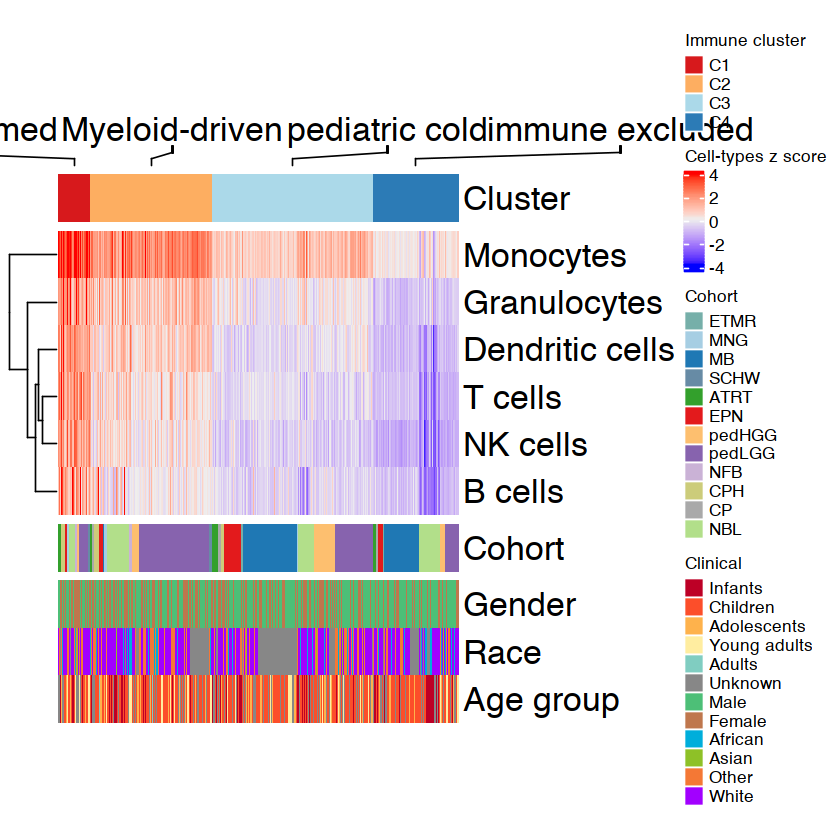

In [32]:
cluster_ha %v% cluster_hm %v% cells_hm %v% cohorts_hm %v% clin_hm

In [33]:
pdf(paste0(plotpath, "IPD_immune_clusters_heatmap.pdf"),
   width = 16, height = 10)

draw(cluster_ha%v% cluster_hm %v% cells_hm %v% cohorts_hm %v% clin_hm,
     heatmap_legend_side = "bottom", gap = unit(0.5, "cm"))

dev.off()

pdf 
  2

# Ridge plots and stats

In [34]:
mygenesets <- as.data.frame(t(geneset_cc_norm))

In [35]:
mygenesets$sample_id <- rownames(mygenesets)

In [36]:
metadata_IC_genesets <- merge(metadata_IC, mygenesets, by = "sample_id")

In [37]:
tcells_rp <- plot_ridge.fx(metadata_IC_genesets, "T_cells") 

bcells_rp <- plot_ridge.fx(metadata_IC_genesets, "B_cells") 

nkcells_rp <- plot_ridge.fx(metadata_IC_genesets, "NK_cells") 

dc_rp <- plot_ridge.fx(metadata_IC_genesets, "DC") 

granul_rp <- plot_ridge.fx(metadata_IC_genesets, "Granulocytes") 

mono_rp <- plot_ridge.fx(metadata_IC_genesets, "Monocytes") 

myeloid_rp <- plot_ridge.fx(metadata_IC_genesets, "Myeloid_cells") 

Picking joint bandwidth of 0.204



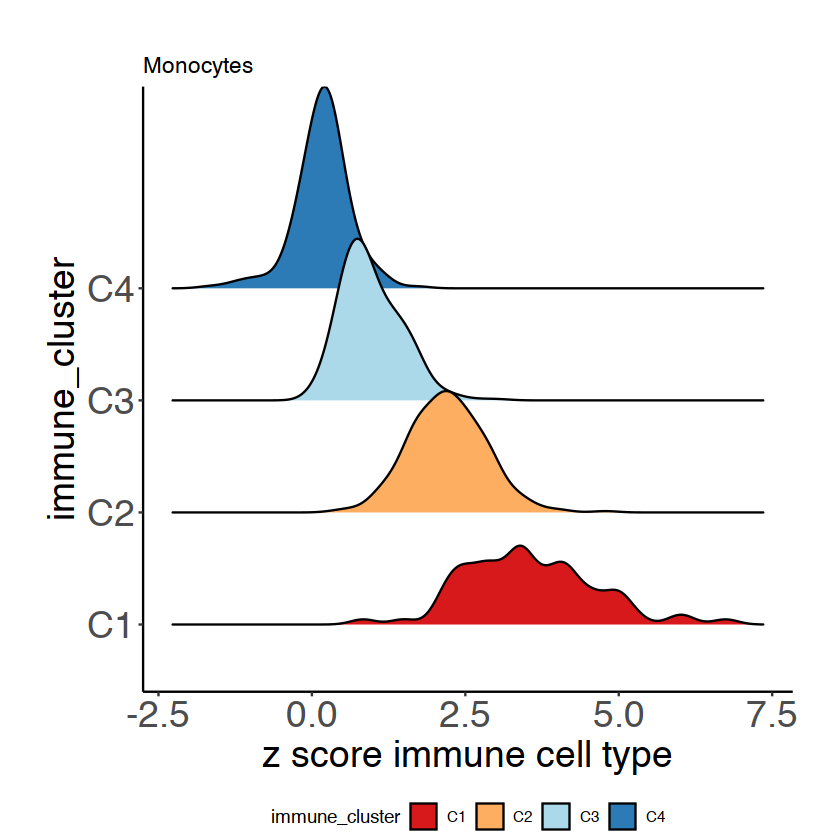

In [38]:
mono_rp

In [39]:
pairwise.t.test(metadata_IC_genesets$T_cells, metadata_IC_genesets$immune_cluster, p.adjust.method = "bonf")


	Pairwise comparisons using t tests with pooled SD 

data:  metadata_IC_genesets$T_cells and metadata_IC_genesets$immune_cluster 

   C1     C2     C3    
C2 <2e-16 -      -     
C3 <2e-16 <2e-16 -     
C4 <2e-16 <2e-16 <2e-16

P value adjustment method: bonferroni 

In [40]:
pairwise.t.test(metadata_IC_genesets$B_cells, metadata_IC_genesets$immune_cluster, p.adjust.method = "bonf")


	Pairwise comparisons using t tests with pooled SD 

data:  metadata_IC_genesets$B_cells and metadata_IC_genesets$immune_cluster 

   C1     C2     C3    
C2 <2e-16 -      -     
C3 <2e-16 <2e-16 -     
C4 <2e-16 <2e-16 <2e-16

P value adjustment method: bonferroni 

In [41]:
pairwise.t.test(metadata_IC_genesets$NK_cells, metadata_IC_genesets$immune_cluster, p.adjust.method = "bonf")


	Pairwise comparisons using t tests with pooled SD 

data:  metadata_IC_genesets$NK_cells and metadata_IC_genesets$immune_cluster 

   C1     C2     C3    
C2 <2e-16 -      -     
C3 <2e-16 <2e-16 -     
C4 <2e-16 <2e-16 <2e-16

P value adjustment method: bonferroni 

In [43]:
pairwise.t.test(metadata_IC_genesets$Monocytes, metadata_IC_genesets$immune_cluster, p.adjust.method = "bonf")


	Pairwise comparisons using t tests with pooled SD 

data:  metadata_IC_genesets$Monocytes and metadata_IC_genesets$immune_cluster 

   C1     C2     C3    
C2 <2e-16 -      -     
C3 <2e-16 <2e-16 -     
C4 <2e-16 <2e-16 <2e-16

P value adjustment method: bonferroni 

In [44]:
pairwise.t.test(metadata_IC_genesets$DC, metadata_IC_genesets$immune_cluster, p.adjust.method = "bonf")


	Pairwise comparisons using t tests with pooled SD 

data:  metadata_IC_genesets$DC and metadata_IC_genesets$immune_cluster 

   C1     C2     C3    
C2 <2e-16 -      -     
C3 <2e-16 <2e-16 -     
C4 <2e-16 <2e-16 <2e-16

P value adjustment method: bonferroni 

In [45]:
pairwise.t.test(metadata_IC_genesets$Granulocytes, metadata_IC_genesets$immune_cluster, p.adjust.method = "bonf")


	Pairwise comparisons using t tests with pooled SD 

data:  metadata_IC_genesets$Granulocytes and metadata_IC_genesets$immune_cluster 

   C1     C2     C3    
C2 <2e-16 -      -     
C3 <2e-16 <2e-16 -     
C4 <2e-16 <2e-16 <2e-16

P value adjustment method: bonferroni 

within each cluster, whats the median difference for cell types?

# Heatmap Cancer type 

In [46]:
tab <- as.data.frame(table(metadata_IC_genesets$cohort), stringsAsFactors = F)
tab <- tab[order(tab$Freq, decreasing = F),]

In [47]:
dim(tab)

[1] 12  2

In [48]:
cancer_IC_mat <- matrix(nrow = 12, ncol = 4,
                       dimnames = list(tab$Var1, c("C1", "C2", "C3", "C4")))

In [49]:
for(i in 1:nrow(cancer_IC_mat)){
    
    mycancer <- metadata_IC_genesets[ metadata_IC_genesets$cohort == rownames(cancer_IC_mat)[i],]    
    freq_tab <- as.data.frame(table(mycancer$immune_cluster), stringsAsFactors = F)
    freq_tab$perc <- freq_tab$Freq/sum(freq_tab$Freq)    
    
    cancer_IC_mat[i, freq_tab$Var1] <- freq_tab$perc *100
}

In [50]:
cancer_IC_mat[is.na(cancer_IC_mat)] <- 0

In [51]:
col_fun= colorRamp2(c(0, 100), c("white", "red"))
    
cancer_hm = Heatmap(cancer_IC_mat,
                    #titles and names   
                    name = "% cancer",   
                    show_row_names = TRUE,
                    show_column_names = TRUE,     
                    #clusters and orders  
                    cluster_columns = FALSE,
                    cluster_rows = FALSE,
                    show_column_dend = TRUE,
                    #aesthestics
                    row_names_side = "left",
                    col = col_fun,
                    column_names_gp = gpar(fontsize = 20),
                    row_names_gp = gpar(fontsize = 20),
                    height = unit(nrow(cancer_IC_mat), "cm"),
                    width = unit(ncol(cancer_IC_mat), "cm"),
                    column_title_gp = gpar(fontsize = 20),
                    column_title = NULL,
                    row_title = NULL)

In [52]:
ha = rowAnnotation(
    `cohort size` = anno_barplot(tab$Freq, bar_width = 1,
                                 gp = gpar(col = "white", fill = "#4d4d4d"), 
                                 border = FALSE,
                                 axis_param = list(at = c(0, 100,200,300)),
                                 width = unit(4, "cm")), 
    show_annotation_name = TRUE)

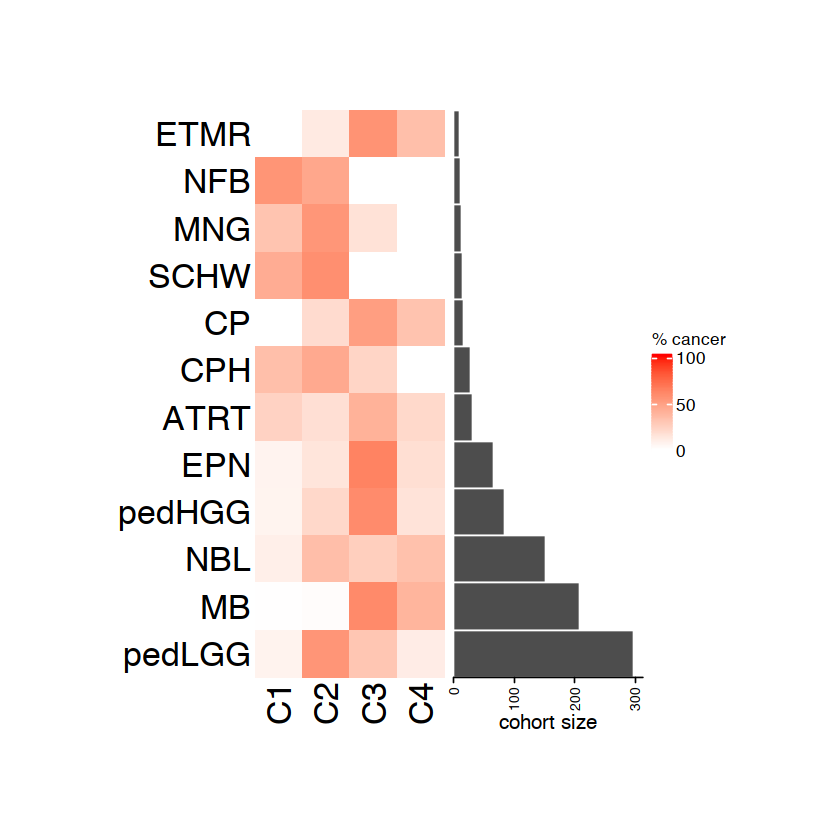

In [53]:
cancer_hm + ha

In [54]:
pdf(paste0(plotpath, "Immune_clusters_cancers.pdf"),
   width = 10, height = 10)

cancer_hm + ha

dev.off()

pdf 
  2

# Heatmap TCGA cluster 

In [55]:
tab <- as.data.frame(table(metadata_IC_genesets$CRI_cluster), stringsAsFactors = F)
tab <- tab[order(tab$Freq, decreasing = F),]

In [56]:
(tab)

,Var1,Freq
,<chr>,<int>
5,TGFbeta dominant,6
1,IFN-gamma dominant,26
6,Wound Healing,64
2,Immunologically quiet,110
3,Inflammatory,148
4,Lymphocyte depleted,554


In [57]:
cri_IC_mat <- matrix(nrow = 6, ncol = 4,
                       dimnames = list(tab$Var1, c("C1", "C2", "C3", "C4")))

In [58]:
for(i in 1:nrow(cri_IC_mat)){
    
    mycancer <- metadata_IC_genesets[ metadata_IC_genesets$CRI_cluster == rownames(cri_IC_mat)[i],]    
    freq_tab <- as.data.frame(table(mycancer$immune_cluster), stringsAsFactors = F)
    freq_tab$perc <- freq_tab$Freq/sum(freq_tab$Freq)    
    
    cri_IC_mat[i, freq_tab$Var1] <- freq_tab$perc *100
}

In [59]:
cri_IC_mat

,C1,C2,C3,C4
TGFbeta dominant,83.333333,16.66667,NA,NA
IFN-gamma dominant,26.923077,61.53846,11.53846,NA
Wound Healing,1.562500,25.00000,23.43750,50.000000
Immunologically quiet,NA,21.81818,54.54545,23.636364
Inflammatory,21.621622,42.56757,29.72973,6.081081
Lymphocyte depleted,4.512635,28.51986,44.76534,22.202166


In [60]:
cri_IC_mat[is.na(cri_IC_mat)] <- 0

In [61]:
col_fun= colorRamp2(c(0, 100), c("white", "red"))
    
cri_hm = Heatmap(cri_IC_mat,
                    #titles and names   
                    name = "% TCGA cluster",   
                    show_row_names = TRUE,
                    show_column_names = TRUE,     
                    #clusters and orders  
                    cluster_columns = FALSE,
                    cluster_rows = FALSE,
                    show_column_dend = TRUE,
                    #aesthestics
                    row_names_side = "left",
                    col = col_fun,
                    column_names_gp = gpar(fontsize = 20),
                    row_names_gp = gpar(fontsize = 20),
                    height = unit(nrow(cri_IC_mat), "cm"),
                    width = unit(ncol(cri_IC_mat), "cm"),
                    column_title_gp = gpar(fontsize = 20),
                    column_title = NULL,
                    row_title = NULL)

In [62]:
ha = rowAnnotation(
    `cohort size` = anno_barplot(tab$Freq, bar_width = 1, 
                                 gp = gpar(col = "white", fill = "#4d4d4d"), 
                                 border = FALSE,
                                 axis_param = list(at = c(0, 100,250,500)),
                                 width = unit(4, "cm")), 
    show_annotation_name = TRUE)

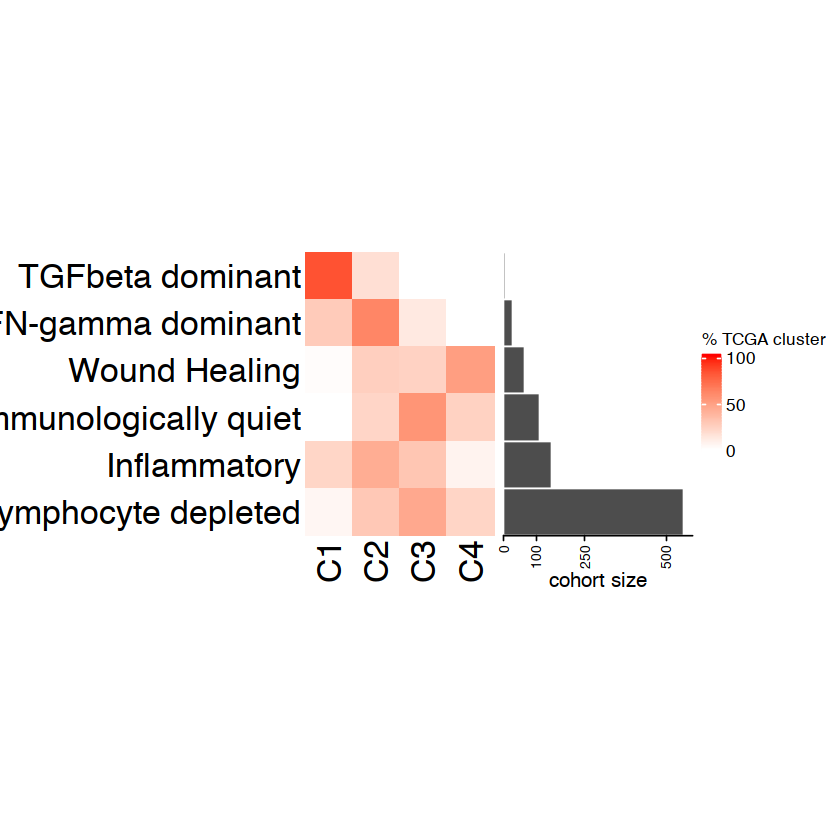

In [63]:
cri_hm + ha

In [64]:
pdf(paste0(plotpath, "Immune_clusters_cri.pdf"),
   width = 10, height = 10)

cri_hm + ha

dev.off()

pdf 
  2